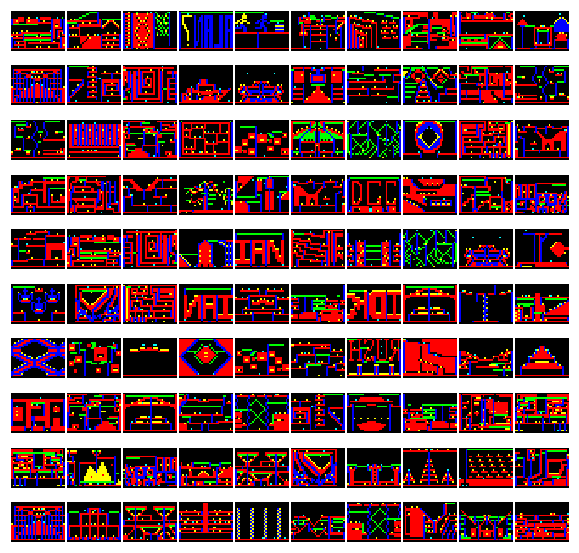

(300, 24, 32, 5)


In [47]:
from __future__ import print_function,division
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import astar

#VAE param
input_path = 'e://python3/cv/levels/lode_runner_5_channel.npy'
gb_w, gb_h, gb_c = 24,32,5
tdata='level'  #level(22*32)*b=1 or mnist(28*28)*b=16
batch_size = 30
total_data = 300
threthod = 0.3
noise_dim = 16   #important part
lr = 1e-3
show_every_img=1000
print_every_loss=100
num_epoch=1000



def translate(images_in):
    images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
    #R
    images[:,:,:,0] = images_in[:,:,:,0]
    #G
    images[:,:,:,1] = images_in[:,:,:,1]
    #B
    images[:,:,:,2] = images_in[:,:,:,2]
    #yellow
    if gb_c > 3:
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
    #cyan
    if gb_c > 4:
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
    return images

def disp_images(images,threthod = threthod,figsize=None):
    images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
    outlist = images_sv
    images = translate(images_sv)
    images = np.reshape(images,[images.shape[0],-1])
    if threthod!=None:
        images[images>=threthod] = 1.0
        images[images<threthod] = 0.0
    sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
    if figsize:
        plt.figure(figsize = figsize)
    else:
        figure = plt.figure(figsize = (sqrtn,sqrtn))
    gs = gridspec.GridSpec(sqrtn,sqrtn)
    gs.update(wspace = 0.05,hspace = 0.05)
    for i,img in enumerate(images):
        tmp = img.reshape([gb_w,gb_h,3])
        if i<100:
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')            
            plt.imshow(tmp) #
    plt.show()
    return outlist


def preprocess(x):
    return 2*x-1.0
def deprocess(x):
    return (x+1.0) / 2.0

def session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config = config)
    return session
def activation(x, alpha = 0.01):# leaky relu
    a = tf.maximum(x,alpha*x)
    return a

def get_solvers(lr = 1e-3, beta1 = 0.5):
    d_solver = tf.train.AdamOptimizer(learning_rate = lr,beta1 = beta1)
    return d_solver

def threthod_func(tin,threthod = 0.5):
    one = tf.ones_like(tin)
    zero = tf.zeros_like(tin)
    tin = tf.where(tin < threthod, x=zero, y=one)
    return tin

def data_augumentation(tin):
    return tin[:,:,::-1,:]

class batch_iter:
    def __init__(self,data,batch_size):
        self.data = data.reshape([data.shape[0],-1])
        self.batch_size = batch_size
        self.iter = 0
    def next_batch(self):
        if self.iter>=len(self.data): 
            np.random.shuffle(self.data)        
            self.iter = 0
        tmp = self.iter
        self.iter += self.batch_size
        return self.data[tmp:tmp+batch_size]

if tdata == 'level':
    imageMatrix1 = np.load(input_path)[:150]
    imageMatrix2 = data_augumentation(imageMatrix1)
    imageMatrix1 = np.vstack((imageMatrix1,imageMatrix2))
    np.random.shuffle(imageMatrix1)
    imageMatrix1 = imageMatrix1[0:total_data]  #----------------------------------
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)
    '''path = "e://python3/cv/"
    file1="shang.png"#"2.jpg"#"chang.png""checker128-var20.png"
    img1 = Image.open(path+str(file1)) 
    imageMatrix1 = np.matrix(img1.getdata())
    def grey_kernel(matrix,L):
        new = np.zeros(matrix.shape[0])
        for i in range(matrix.shape[0]):
            new[i]=np.uint8(round(0.299*matrix[i,0]+0.587*matrix[i,1]+0.114*matrix[i,2]))#matrix[i,0]#      
        return new
    imageMatrix1 = grey_kernel(imageMatrix1,256)
    imageMatrix1 = np.reshape(imageMatrix1,[1,-1])
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)'''
if tdata == 'mnist':
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MNIST_data',one_hot = False)
    disp_images(mnist.train.next_batch(16)[0])# [0] stands for batch x, [1] stands for batch y
    print(mnist.train.next_batch(16)[0].shape) #one global para 12
    print(type(mnist))


In [48]:
def gaussian_MLP_encoder(x_in): #input should be with intensity 0~1
    with tf.variable_scope("encoder"):
        init = tf.contrib.layers.xavier_initializer()
        x_in = preprocess(x_in)
        fc1 = tf.layers.dense(inputs=x_in,units=max(gb_w,gb_h)**2*gb_c, #batch*32*32*3
                              activation=tf.nn.relu,kernel_initializer = init,name='dense_0')
        
        cv2 = fc1
        fc1 = tf.reshape(fc1,[-1,max(gb_w,gb_h),max(gb_w,gb_h),gb_c])
        
        cv1 = tf.layers.conv2d(fc1,8,4,strides=2,padding='same',  #batch*16*16*8
                            kernel_initializer=init,name='e_conv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='e_batchnorm_1')
        cv1 = activation(cv1) 
        cv2 = tf.layers.conv2d(cv1,16,4,strides=2,padding='same',  #batch*8*8*16
                            kernel_initializer=init,name='e_conv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='e_batchnorm_2')
        cv2 = activation(cv2) 
        cv2 = tf.reshape(cv2,[-1,8*8*16])
        
        '''cv2 = tf.nn.dropout(cv2,keep_prob=0.5)'''
        gaussian_params = tf.layers.dense(inputs=cv2,units=noise_dim,
                                          kernel_initializer = init,name='dense_3')
        gaussian_params = tf.nn.tanh(0.01*gaussian_params)
        '''n_output = gaussian_params.shape[1]//2
        mean = gaussian_params[:,:n_output]
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:,n_output:])'''
        return gaussian_params#mean, stddev
def bernoulli_MLP_decoder(z_in):
    with tf.variable_scope("decoder"):
        init = tf.contrib.layers.xavier_initializer()
        '''z_in = tf.nn.dropout(z_in,keep_prob=0.5)'''
        fc1 = tf.layers.dense(inputs=z_in,units=8*8*16,activation=tf.nn.relu,kernel_initializer = init,name='dense_11')
        
        
        fc1 = tf.reshape(fc1,[-1,8,8,16]) 
        
        cv1 = tf.layers.conv2d_transpose(fc1,filters=8,kernel_size=4,strides=2,padding='same', #batch*16*16*8
                                                kernel_initializer=init,name='d_deconv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='d_batchnorm_1')
        cv1 = tf.nn.relu(cv1)
        
        cv2 = tf.layers.conv2d_transpose(cv1,filters=gb_c,kernel_size=4,strides=2,padding='same', #batch*32*32*3
                                                kernel_initializer=init,name='d_deconv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='d_batchnorm_2')
        cv2 = tf.nn.relu(cv2)        
        cv2 = tf.reshape(cv2,[-1,max(gb_w,gb_h)**2*gb_c]) 
        
        
        fc2 = tf.layers.dense(inputs=cv2,units=gb_w*gb_h*gb_c,
                              kernel_initializer = init,name='dense_00') #11111
        fc2 = tf.nn.sigmoid(fc2)

        #fc2 = threthod_func(fc2,threthod = 0.5)
        return fc2  #output is with intensity 0~1

     
def autoencoder(x):
    with tf.variable_scope("autoencoder"):
        z = gaussian_MLP_encoder(x)
        #z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
        #z = tf.nn.tanh(z)
        y = bernoulli_MLP_decoder(z)
        marginal_likelihood = tf.reduce_sum(x*tf.log(1e-6+y)+(1-x)*tf.log(1e-6+1-y),1)
        #KL_divergence = 10*0.5 * tf.reduce_sum(tf.square(mu)+tf.square(sigma) - tf.log(1e-8 + tf.square(sigma))-1, 1)

        ELBO = tf.reduce_mean(marginal_likelihood)# - tf.reduce_mean(KL_divergence)
        loss = -ELBO

        return y, z, loss#, -tf.reduce_mean(marginal_likelihood), tf.reduce_mean(KL_divergence),mu,sigma
    
def train(sess,D_train_step,D_loss,show_every=50,print_every=10,batch_size=1,num_epoch=10):
    if tdata=='level':
        come_in_data = imageMatrix1 #np.random.uniform(0,1,size=[1,22*32]) 
        data = batch_iter(come_in_data,batch_size)
        max_iter = int(len(data.data)*num_epoch/batch_size)
    elif tdata=='mnist':
        max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        if it and (it % show_every == 0):
            print('generated img')
            sap_noise = np.random.uniform(-1, 1,[16,noise_dim])
            samples = sess.run(output_real, feed_dict = {latent: sap_noise})
            fig = disp_images(samples[:batch_size if batch_size<16 else 16])# one global para

            print()
        #fetch the minibatch and train
        if tdata=='level':
            minibatch = data.next_batch()
        elif tdata=='mnist':
            minibatch,_ = mnist.train.next_batch(batch_size)
        
        _,D_loss_curr,opr = sess.run([D_train_step,D_loss,output_real],feed_dict = {x:minibatch})
        if D_loss_curr<-(10e5): break  
        if it and (it % show_every == 0):
            print('test img')            
            disp_images(opr[:batch_size if batch_size<16 else 16])  # one global para
   
        if (it % print_every == 0):
            print('Iter:{}, loss:{:.4}'.format(it,D_loss_curr))
            #print('   encoder_loss:{:.4}, decoder_loss:{:.4}'.format(tml,tkl))


    print('Final images')
    sap_noise = np.random.uniform(-1, 1,[100,noise_dim])
    samples = sess.run(output_real, feed_dict = {latent: sap_noise})
    fig = disp_images(samples)# one global para

Iter:0, loss:2.662e+03
Iter:100, loss:823.1
Iter:200, loss:797.9
Iter:300, loss:743.8
Iter:400, loss:684.8
Iter:500, loss:701.8
Iter:600, loss:674.6
Iter:700, loss:562.1
Iter:800, loss:527.7
Iter:900, loss:488.0
generated img


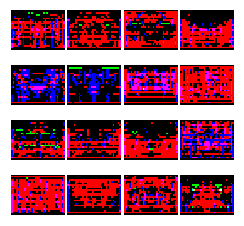


test img


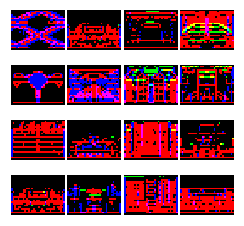

Iter:1000, loss:372.5
Iter:1100, loss:321.9
Iter:1200, loss:217.9
Iter:1300, loss:171.4
Iter:1400, loss:137.3
Iter:1500, loss:89.36
Iter:1600, loss:64.44
Iter:1700, loss:24.99
Iter:1800, loss:17.4
Iter:1900, loss:12.1
generated img


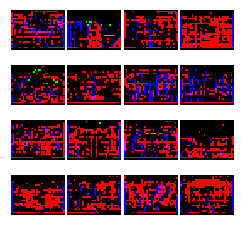


test img


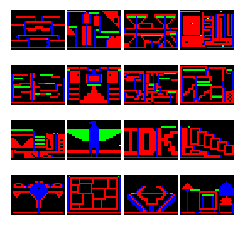

Iter:2000, loss:10.9
Iter:2100, loss:9.646
Iter:2200, loss:2.755
Iter:2300, loss:3.438
Iter:2400, loss:2.129
Iter:2500, loss:1.09
Iter:2600, loss:1.716
Iter:2700, loss:0.9264
Iter:2800, loss:1.566
Iter:2900, loss:1.63
generated img


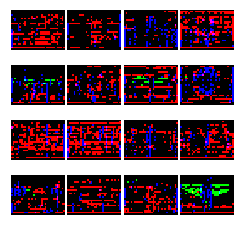


test img


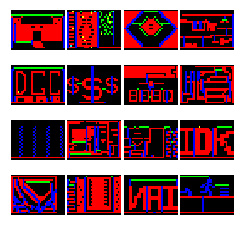

Iter:3000, loss:0.5176
Iter:3100, loss:492.2
Iter:3200, loss:11.12
Iter:3300, loss:2.857
Iter:3400, loss:3.637
Iter:3500, loss:0.8572
Iter:3600, loss:2.291
Iter:3700, loss:0.7416
Iter:3800, loss:1.578
Iter:3900, loss:1.246
generated img


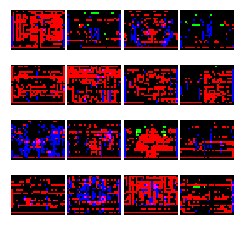


test img


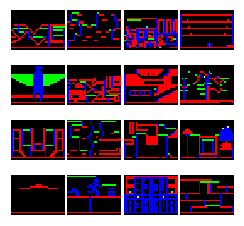

Iter:4000, loss:1.038
Iter:4100, loss:0.3514
Iter:4200, loss:0.8419
Iter:4300, loss:0.4681
Iter:4400, loss:1.355
Iter:4500, loss:0.6123
Iter:4600, loss:0.9159
Iter:4700, loss:0.2526
Iter:4800, loss:0.1843
Iter:4900, loss:0.1616
generated img


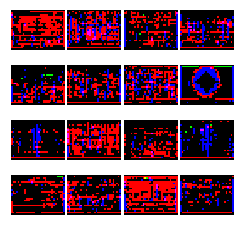


test img


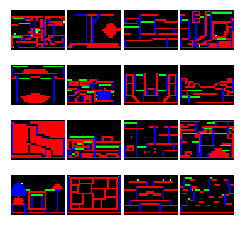

Iter:5000, loss:0.698
Iter:5100, loss:0.2709
Iter:5200, loss:0.215
Iter:5300, loss:2.458
Iter:5400, loss:1.954
Iter:5500, loss:0.104
Iter:5600, loss:2.811
Iter:5700, loss:1.926
Iter:5800, loss:0.7428
Iter:5900, loss:0.07093
generated img


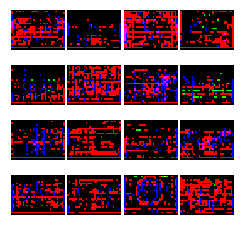


test img


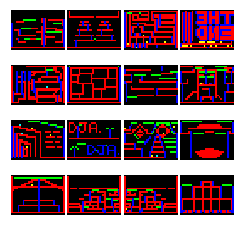

Iter:6000, loss:1.911
Iter:6100, loss:2.038
Iter:6200, loss:0.5815
Iter:6300, loss:0.06068
Iter:6400, loss:0.2573
Iter:6500, loss:0.05868
Iter:6600, loss:0.2612
Iter:6700, loss:0.05892
Iter:6800, loss:0.1866
Iter:6900, loss:633.7
generated img


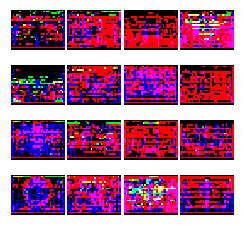


test img


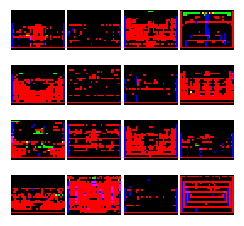

Iter:7000, loss:494.6
Iter:7100, loss:276.9
Iter:7200, loss:155.3
Iter:7300, loss:62.55
Iter:7400, loss:16.39
Iter:7500, loss:7.858
Iter:7600, loss:4.043
Iter:7700, loss:2.178
Iter:7800, loss:1.387
Iter:7900, loss:1.342
generated img


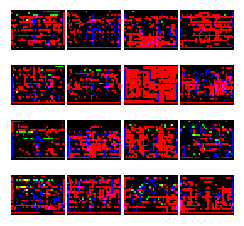


test img


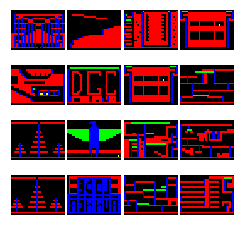

Iter:8000, loss:1.134
Iter:8100, loss:0.8156
Iter:8200, loss:0.5421
Iter:8300, loss:0.5636
Iter:8400, loss:0.8264
Iter:8500, loss:0.2892
Iter:8600, loss:0.3172
Iter:8700, loss:0.2385
Iter:8800, loss:0.8256
Iter:8900, loss:0.7131
generated img


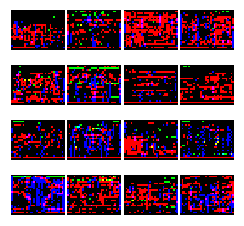


test img


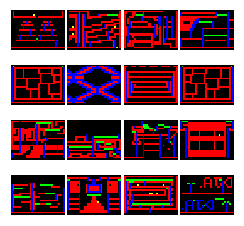

Iter:9000, loss:0.4684
Iter:9100, loss:0.2011
Iter:9200, loss:0.1957
Iter:9300, loss:0.284
Iter:9400, loss:0.1193
Iter:9500, loss:0.3851
Iter:9600, loss:0.2396
Iter:9700, loss:0.8456
Iter:9800, loss:0.5178
Iter:9900, loss:763.1
Final images


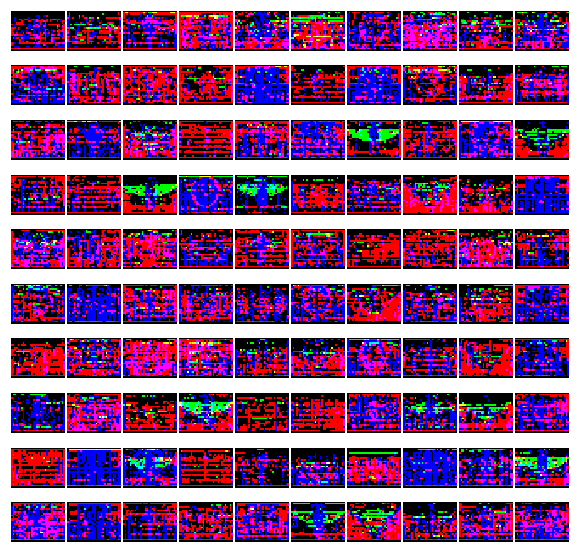

In [49]:
tf.reset_default_graph()
#batch_size = 16
#noise_dim = 50   #important part
x = tf.placeholder(tf.float32,[None,gb_w*gb_h*gb_c]) #-----------------------------------------

output_real, latent, d_loss = autoencoder(x)


d_solver = get_solvers(lr=lr)
d_train_step = d_solver.minimize(d_loss)

sess = session()
try:
    with tf.device("/cpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        train(sess,d_train_step,d_loss,show_every=show_every_img,print_every=print_every_loss,batch_size=batch_size, num_epoch=num_epoch)    
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration") 

    


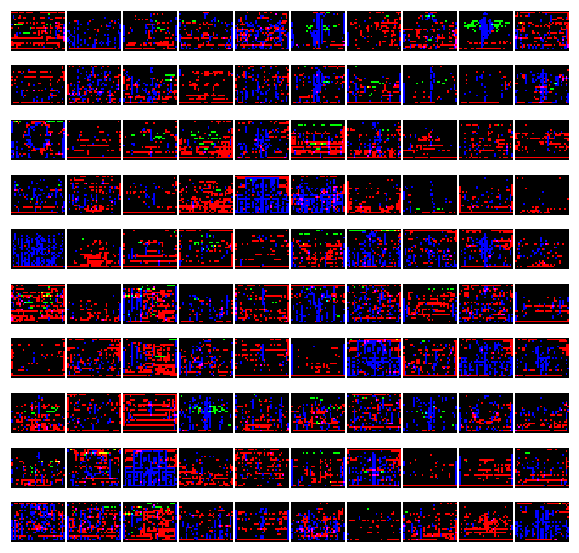

In [71]:
generate_num = 9700
sap_noise = np.random.uniform(-1, 1,[generate_num,noise_dim])
samples = sess.run(output_real, feed_dict = {latent: sap_noise})
fig = disp_images(samples,threthod=0.6)# one global para\
img_save = np.vstack((fig,imageMatrix1))
np.random.shuffle(img_save)
np.save("vae_v4",img_save,allow_pickle=False,fix_imports=True)


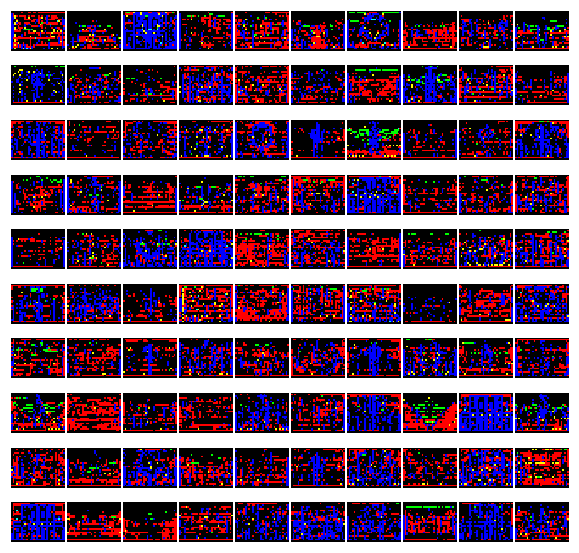

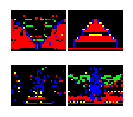

(4, 3840)


In [86]:
sth = np.load("e://python3/vae_v4.npy")
ec_imglist = []
for i in range(sth.shape[0]):
    #print('process ',i)
    _, ec_img  = Util.encoding_img(sth[i])
    ec_imglist.append(ec_img)
ec_imglist = np.array(ec_imglist)
_ = Util.disp_images(ec_imglist[700:800])
ec_picked = ec_imglist[[132,205,461,726]]
_ = Util.disp_images(ec_picked)
print(ec_picked.shape)
np.save("visualizevae_v4",ec_picked,allow_pickle=False,fix_imports=True)

In [12]:
#sess.close()

In [56]:
#----evolution
class Util:
    def img2gene(level_in):  #[150,22,32,3]
        #if not level_in: return 'error'
        gene = level_in.reshape([level_in.shape[0],-1])
        return gene  #output 150,22*32,3
    def translate(images_in):
        images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
        #R
        images[:,:,:,0] = images_in[:,:,:,0]
        #G
        images[:,:,:,1] = images_in[:,:,:,1]
        #B
        images[:,:,:,2] = images_in[:,:,:,2]
        #yellow
        if gb_c > 3:
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
        #cyan
        if gb_c > 4:
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
        return images

    def disp_images(images,threthod=0.3,figsize=None,gb_w=gb_w,gb_h=gb_h,gb_c=gb_c):
        images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
        outlist = images_sv
        images = Util.translate(images_sv)
        images = np.reshape(images,[images.shape[0],-1])
        if threthod!=None:
            images[images>=threthod] = 1.0
            images[images<threthod] = 0.0
        sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
        if figsize:
            plt.figure(figsize = figsize)
        else:
            figure = plt.figure(figsize = (sqrtn,sqrtn))
        gs = gridspec.GridSpec(sqrtn,sqrtn)
        gs.update(wspace = 0.05,hspace = 0.05)
        for i,img in enumerate(images):
            tmp = img.reshape([gb_w,gb_h,3])
            if i<100:
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')            
                plt.imshow(tmp) #
        plt.show()  
    def encoding_img(np_in):
        np_in = np_in.reshape([gb_w,gb_h,-1])
        a = np.zeros(np_in.shape)
        b = np.where(np_in[:,:,0] > 0.5, 1, 0)
        c = np.where(np_in[:,:,1] > 0.5, 5, 0)
        d = np.where(np_in[:,:,2] > 0.5, 10, 0)
        e = b + c + d
        if gb_c > 3:
            bb = np.where(np_in[:,:,3] > 0.5, 50, 0)
            e = e + bb
        if gb_c > 4:
            cc = np.where(np_in[:,:,4] > 0.5, 100, 0)
            e = e + cc
        
        f = np.zeros(e.shape)
        f = f.astype('str')
        
        
        f[np.where(e==0)] = '.'
        if list(np.where(e==0)): 
            f[(np.array([np.where(e==0)[0][0]]),np.array([np.where(e==0)[1][0]]))] = 'M'
        
        condb = np.where((e>0) & (e<5))
        f[condb] = 'b'
        a[(condb[0],condb[1],0*np.ones(len(condb[0]),dtype=np.int64))] = 1
        
        condr = np.where((e>4) & (e<10))
        f[condr] = '-'
        a[(condr[0],condr[1],1*np.ones(len(condr[0]),dtype=np.int64))] = 1
        
        condl = np.where((e>9) & (e<50))
        f[condl] = '#'
        a[(condl[0],condl[1],2*np.ones(len(condl[0]),dtype=np.int64))] = 1
        
        if gb_c > 3:
            condg = np.where((e>49) & (e<100))
            f[condg] = 'G'
            a[(condg[0],condg[1],3*np.ones(len(condg[0]),dtype=np.int64))] = 1
            
        if gb_c > 4:
            conde = np.where(e>99)
            f[conde] = 'E'
            a[(conde[0],conde[1],4*np.ones(len(conde[0]),dtype=np.int64))] = 1        

        '''
        st_lock = None
        for i in range(gb_w):
            for j in range(gb_h):
                if e[i][j] == 0:
                    f[i][j] = "."
                    if st_lock == None:
                        f[i][j] = 'M'
                        st_lock = True
                        
                if (e[i][j] > 0 and e[i][j] < 5):
                    f[i][j] = "b"
                    a[i][j][0] = 1
                if  (e[i][j] > 4 and e[i][j] < 10):
                    f[i][j] = "-"
                    a[i][j][1] = 1
                if e[i][j] > 9:
                    f[i][j] = "#"
                    a[i][j][2] = 1
        if not st_lock: f[0][0] = 'M'#'''
        np_in = np_in.reshape([-1])
        a = a.reshape([-1])
        f = list(f)
        return f, a       
    def fitness(population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     
    
class Generic:
    def __init__(self,data,rawset,crossover_rate=1.0,mutate_rate = 0.25,n_population = 15,
                 DNA_size=gb_w*gb_h*gb_c,n_iterations = 3): #[150,704*3]
        self.rawset = rawset
        print(self.rawset.shape)
        self.population = data
        self.crossover_rate = crossover_rate
        self.mutate_rate = mutate_rate
        self.n_population = n_population
        self.DNA_size = DNA_size
        self.n_iterations = n_iterations
        
    def fitness(self,population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     

    def select(self,population,fitness_score):
        fitness_score = fitness_score + 1e-4
        idx = np.random.choice(np.arange(population.shape[0]), size=self.n_population, replace=False,
                               p=fitness_score/fitness_score.sum())
        return population[idx], fitness_score[idx]
   
    def create_child(self,idx_p,parent,pop): #[1,704*3], [150,704*3]
        index = np.random.randint(0,pop.shape[0],size=1)
        if index != idx_p:
            if np.random.rand()<self.crossover_rate:
                parent, same = self.segment_mask_inheret(parent,pop[index],partition=2)       
                return parent, same
            else:
                return parent, 'same'
        else:
            return parent,'same'

    def mutate_child(self, child):
        #child, same = self.segment_mask_mutate(child)
        same = 'same'  
        lt = sess.run(latent,feed_dict = {x:child.reshape([1,-1])})
        for i in range(len(lt[0])):
            if np.random.rand()<self.mutate_rate:
                val = np.random.rand()*2-1.0
                if val != lt[0][i]:
                    same = 'different'
                lt[0][i] = val
            
        op_real = sess.run(output_real,feed_dict = {latent:lt})
        child = op_real[0].reshape([gb_w,gb_h,gb_c])
        return child, same
    
    def segment_mask_inheret(self,data_a,data_b,partition=1):#[22,32,3]
        data_a = data_a.reshape([gb_w,gb_h,-1])
        data_b = data_b.reshape([gb_w,gb_h,-1])
        child = np.zeros(data_a.shape)
        mask = np.random.randint(0,2,size=(partition+1,partition+1)).astype(np.bool)
        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        same = ''
        if partition==2:
            sp_ii, sp_jj = sp_i, sp_j
            while sp_ii == sp_i:
                sp_ii = random.randint(0,gb_w)
            while sp_jj == sp_j:
                sp_jj = random.randint(0,gb_h)
            sp_i, sp_ii = (sp_i, sp_ii) if sp_i<sp_ii else (sp_ii,sp_i)
            sp_j, sp_jj = (sp_j, sp_jj) if sp_j<sp_jj else (sp_jj,sp_j)
        if partition == 1:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[sp_i:,:sp_j,:] = data_a[sp_i:,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:,:sp_j,:] #2
            child[:sp_i,sp_j:,:] = data_a[:sp_i,sp_j:,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:,:] #3
            child[sp_i:,sp_j:,:] = data_a[sp_i:,sp_j:,:] if mask[1][1]==1 else data_b[sp_i:,sp_j:,:] #4
            same = 'different' if (mask[0][0] or mask[1][0] or mask[0][1] or mask[1][1]) else 'same'
        if partition==2:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[:sp_i,sp_j:sp_jj,:] = data_a[:sp_i,sp_j:sp_jj,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:sp_jj,:] #2
            child[:sp_i,sp_jj:,:] = data_a[:sp_i,sp_jj:,:] if mask[0][2]==1 else data_b[:sp_i,sp_jj:,:] #3
            child[sp_i:sp_ii,:sp_j,:] = data_a[sp_i:sp_ii,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:sp_ii,:sp_j,:] #4
            
            child[sp_i:sp_ii,sp_j:sp_jj,:] = data_a[sp_i:sp_ii,sp_j:sp_jj,:] if mask[1][1]==1 else data_b[sp_i:sp_ii,sp_j:sp_jj,:] #5
            child[sp_i:sp_ii,sp_jj:,:] = data_a[sp_i:sp_ii,sp_jj:,:] if mask[1][2]==1 else data_b[sp_i:sp_ii,sp_jj:,:] #6
            child[sp_ii:,:sp_j,:] = data_a[sp_ii:,:sp_j,:] if mask[2][0]==1 else data_b[sp_ii:,:sp_j,:] #7
            child[sp_ii:,sp_j:sp_jj,:] = data_a[sp_ii:,sp_j:sp_jj,:] if mask[2][2]==1 else data_b[sp_ii:,sp_j:sp_jj,:] #8 
            child[sp_ii:,sp_jj:,:] = data_a[sp_ii:,sp_jj:,:] if mask[2][1]==1 else data_b[sp_ii:,sp_jj:,:] #9
            same = 'different' if (mask[0][0] or mask[0][1] or mask[0][2] or\
                              mask[1][0] or mask[1][1] or mask[1][2] or\
                               mask[2][0] or mask[2][1] or mask[2][2]) else 'same'  

        child = child.reshape([-1])
        return child, same
    
    def segment_mask_mutate(self,data,partition=1):
        data = data.reshape([gb_w,gb_h,-1])
        child = data
        mask = np.random.rand(partition+1,partition+1)

        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        idx = 0
        same = 'same'
        if mask[0][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,:sp_j,:] = self.rawset[idx,:sp_i,:sp_j,:]
        if mask[1][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,:sp_j,:] = self.rawset[idx,sp_i:,:sp_j,:]
        if mask[0][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,sp_j:,:] = self.rawset[idx,:sp_i,sp_j:,:]
        if mask[1][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,sp_j:,:] = self.rawset[idx,sp_i:,sp_j:,:]
        child = child.reshape([-1])
        return child, same
    
    def evolution(self):
        for i in range(self.n_iterations):
            fitness_score, refined_imglist = self.fitness(self.population)
            self.population = refined_imglist
            self.population, fitness_score = self.select(self.population,fitness_score)
            
            tmp_save = self.population
            best_person = self.population[np.argmax(fitness_score)]
            
            if i%1 == 0:
                print('{} th evolution, score_max:{:.4}, score_min:{:.4},'.format(i, np.max(fitness_score),
                                                                                 np.min(fitness_score)))
                print(fitness_score)
            if i and i%1 == 0:
                Util.disp_images(self.population)
            #if np.min(fitness_score)>0.85: break    
            parent_tmp = list(self.population)
            for idx_p,parent in enumerate(self.population):
                child, same1 = self.create_child(idx_p, parent, self.population)
                child, same2 = self.mutate_child(child) 
                if same1 != 'same' or same2 != 'same':
                    parent_tmp.append(child)
            self.population = np.array(parent_tmp)
        self.population = tmp_save
        self.best_person = best_person

epoch: 0 ,start----------------------------------------------


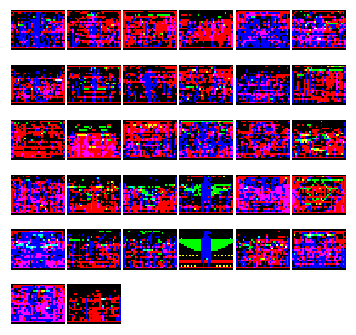

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02391,
[0.76933077 0.67542468 0.79797234 0.8962039  0.56174384 0.90919091
 0.18581429 0.43293582 0.85237273 0.97684419 0.84625385 0.21136761
 0.51292051 0.18928919 0.89483684 0.6628907  0.58237848 0.14824815
 1.0001     0.64483684 0.1601     0.73621111 0.16480588 0.5501
 0.63167895 0.07802208 0.38971039 0.15473918 0.10968904 0.06766757
 0.09220526 0.02390952]
1 th evolution, score_max:1.0, score_min:0.08245,
[0.22629048 0.23694211 0.72951176 0.13105238 0.7126     0.63245294
 0.08245294 0.83539412 0.23198406 0.86121111 0.18302683 0.75591395
 0.60536316 0.27641579 0.18488261 0.77183913 0.53633188 0.97478354
 0.67133288 0.63301139 1.0001     0.7033967  0.85724286 0.14644146
 0.70676667 0.96885    0.21528987 0.7973973  0.0990011  0.4085507
 0.67958718 0.2501    ]


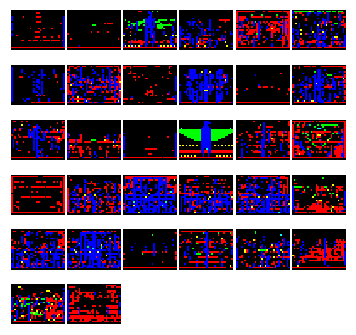

2 th evolution, score_max:1.0, score_min:0.02713,
[0.7501     0.2184908  0.90919091 0.84732222 0.56954444 0.97600361
 0.80565556 0.91314348 0.15594416 0.96163846 0.4401     0.62205122
 1.0001     0.72068824 0.75352466 0.71286596 0.55892353 0.20905522
 0.28135    0.43253243 0.56800123 1.0001     0.17343333 0.26875672
 0.29497179 0.7251     0.74334324 0.19763086 0.2001     0.02712703
 0.6801     0.59766098]


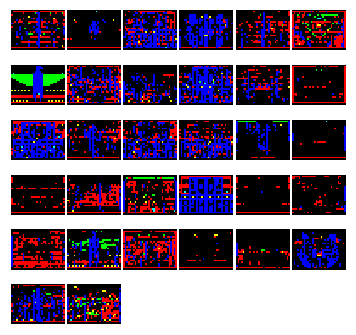

3 th evolution, score_max:1.0, score_min:0.1251,
[0.58898889 0.25935926 0.96306296 0.71438571 0.96933077 0.1251
 1.0001     0.64112564 1.0001     0.84156341 0.98727949 0.19188082
 0.82152857 0.66676667 0.57841325 0.72141148 0.42263521 0.27641579
 0.46997952 0.81438571 0.92317692 0.55565556 0.20299855 0.71438571
 0.3001     0.5506618  0.35375854 0.79022346 0.79771905 0.6970697
 0.8001     0.25383134]


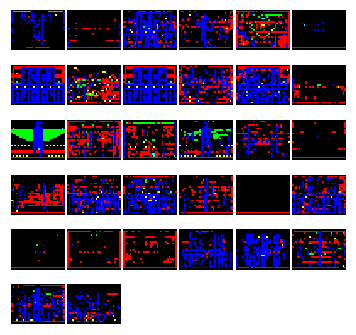

4 th evolution, score_max:1.0, score_min:0.145,
[0.71885    0.90550541 0.70977742 0.98621111 0.89343333 0.7126
 0.76839268 0.46845443 1.0001     0.8046977  0.22901566 0.31353284
 0.80779231 0.57362941 0.92657059 0.26096957 1.0001     0.94454444
 0.80497805 0.85375854 0.21186471 0.6001     0.46521628 0.74368974
 0.24715882 0.17751935 0.97904737 0.81343333 0.77282727 0.8001
 0.14502754 0.28957368]


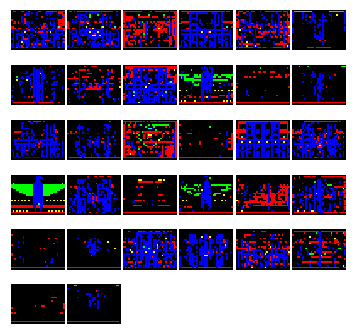

5 th evolution, score_max:1.0, score_min:0.2001,
[0.21927808 0.89020989 0.7001     0.81343333 1.0001     0.90814598
 0.93516494 0.83343333 0.69240769 0.5001     0.25326456 0.8251
 1.0001     0.24060633 0.98517463 0.84792609 0.78676667 0.921975
 0.82904737 0.91790822 0.2001     0.78957368 0.54771905 0.83343333
 0.28581429 0.25343333 0.82061282 0.8751     0.23265814 0.80732892
 0.57756479 1.0001    ]


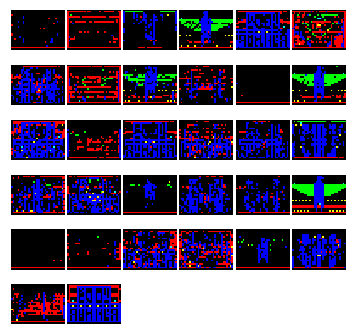

6 th evolution, score_max:1.0, score_min:0.0626,
[0.81343333 0.68975517 0.52574103 0.98744177 0.77429355 0.75372319
 0.0626     0.78471538 1.0001     0.7501     0.98694211 0.2174913
 0.82288481 1.0001     0.79357826 0.65763425 0.83554304 0.91473415
 0.77037027 0.67958718 1.0001     0.85907436 0.84732222 0.15126279
 0.79497179 0.73265814 0.76839268 0.38719677 1.0001     0.85724286
 0.24106386 0.9383716 ]


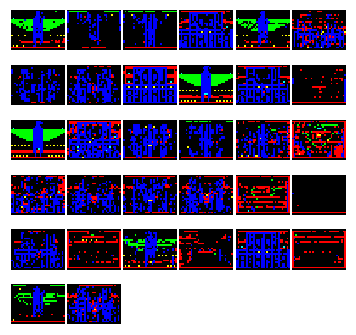

7 th evolution, score_max:1.0, score_min:0.06677,
[0.3751     0.82301667 0.8626     0.53256753 0.88742394 0.94946709
 0.98694211 0.79176667 0.85724286 0.75913614 0.7501     0.86676667
 0.19763086 0.34220526 0.6876     0.18581429 1.0001     0.79421765
 0.66676667 0.97024925 0.67083171 0.97737273 0.63646364 0.21222121
 0.75651026 0.69343333 0.73573218 0.79320345 1.0001     0.06676667
 0.97600361 0.22362941]


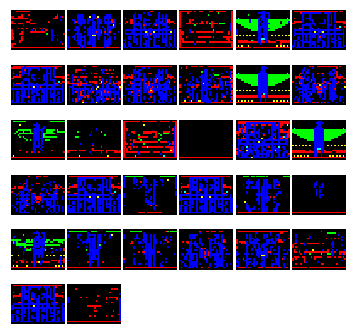

8 th evolution, score_max:1.0, score_min:0.1807,
[0.97600361 0.83108592 0.68302683 0.7722519  0.921975   0.69746842
 0.92217792 0.26163846 0.75318642 0.69630253 0.91676667 0.73503976
 1.0001     0.71885    0.90287778 0.95131951 1.0001     0.65394615
 1.0001     0.73224286 0.67615634 1.0001     0.27282727 0.9517129
 0.91473415 0.81343333 0.98847209 0.21631622 0.80529481 0.18065556
 0.5484871  0.69240769]


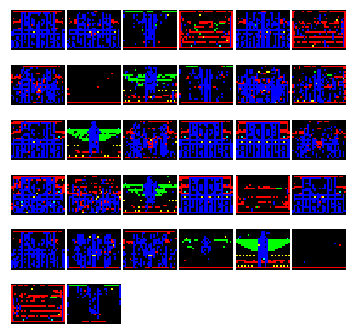

9 th evolution, score_max:1.0, score_min:0.203,
[0.98676667 0.65343333 0.3256814  1.0001     0.94328182 0.57841325
 0.74035974 0.82726049 0.89562239 0.21438571 0.88415797 0.23694211
 0.24400244 0.84347349 0.21927808 0.86121111 0.98621111 0.72982973
 1.0001     0.7028027  0.71438571 0.79756835 1.0001     0.97024925
 0.98494848 0.83539412 0.83343333 1.0001     0.20299855 0.68503151
 1.0001     0.63646364]


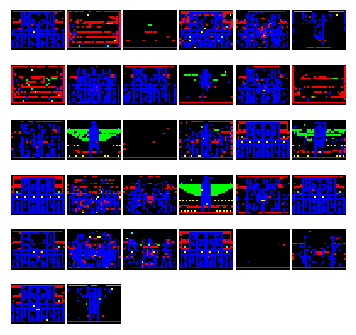

epoch: 0 ,conclusion
raw population


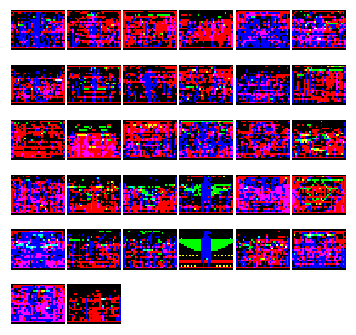

final image


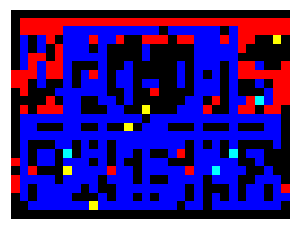

final population


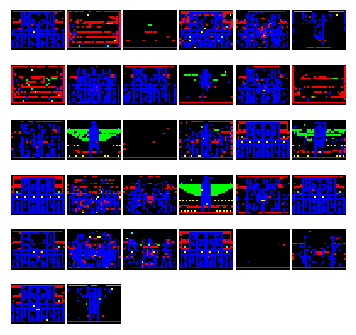

epoch: 1 ,start----------------------------------------------


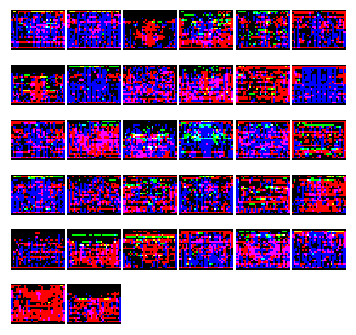

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02363,
[0.94815195 0.90133457 0.84941507 0.7601     0.73503976 0.83343333
 0.63167895 1.0001     0.85145135 1.0001     0.89544884 0.75913614
 0.8751     0.13245294 0.62305082 0.67615634 0.7973973  0.96351463
 0.82768621 0.81091081 0.63778116 0.68684699 0.69328182 0.17987528
 0.09732222 0.57152857 0.1955023  0.18065556 0.5376     0.14295714
 0.02362941 0.02574103]
1 th evolution, score_max:1.0, score_min:0.06767,
[0.42538736 0.06766757 0.88415797 0.7376     0.66676667 1.0001
 0.18928919 0.24106386 0.84956237 0.7038037  0.2501     0.77037027
 0.35536316 0.90598235 0.80256914 0.97307297 0.86429753 0.7251
 0.22378421 0.91081429 0.5943029  0.26839268 0.86496486 0.4376
 0.71804872 0.82936829 0.24685325 0.79357826 0.84792609 0.91186471
 0.98471538 0.70741707]


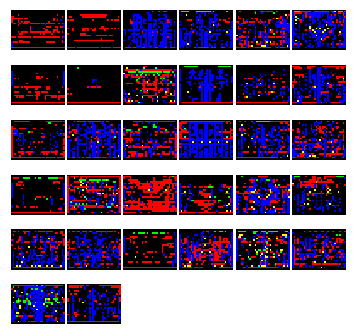

2 th evolution, score_max:1.0, score_min:0.1221,
[0.93268427 0.90227391 0.8975359  0.7601     0.98727949 0.59780115
 0.66207183 0.24106386 0.86676667 0.22676667 0.42475753 0.26480588
 0.98343333 0.7601     0.65527241 0.78581429 0.91368025 0.4495382
 0.81937711 0.69240769 0.5626     0.7601     1.0001     0.29240769
 0.16139032 0.41901892 0.43599744 0.83554304 0.81937711 0.12205122
 0.2401     0.23297671]


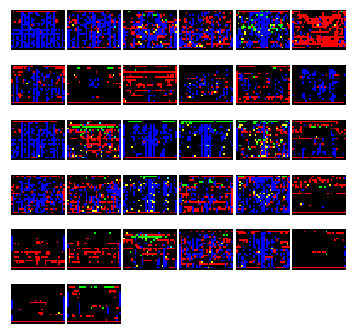

3 th evolution, score_max:1.0, score_min:0.04716,
[0.78092192 0.74400244 0.23621111 0.94127647 0.05962381 0.4138931
 0.96979697 0.34676667 0.86373636 0.19057619 1.0001     0.98805181
 0.8001     0.68862459 0.89865072 0.91901892 0.2001     0.71651791
 1.0001     0.7722519  0.23539412 0.0751     0.48790488 0.19412985
 0.7601     0.1370863  0.91149241 0.04715882 0.88245294 0.26592278
 0.26398889 0.87189487]


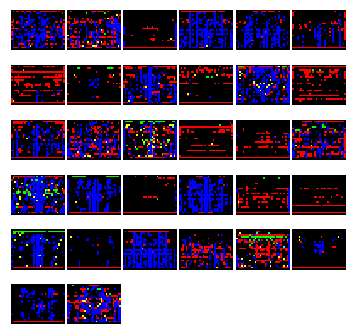

4 th evolution, score_max:1.0, score_min:0.1506,
[0.86676667 0.71885    0.94946709 0.79555455 0.2001     1.0001
 0.15063763 0.26676667 0.27641579 0.6001     1.0001     0.2196122
 1.0001     0.52390952 0.96480588 0.21631622 0.9011989  0.19412985
 0.44272295 0.6376     0.93343333 0.97540864 0.83960617 0.93253243
 0.81438571 0.73694211 0.92967746 0.17293951 0.23198406 0.28875979
 0.36373636 0.71438571]


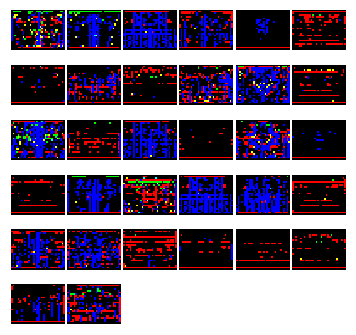

5 th evolution, score_max:1.0, score_min:0.1024,
[0.43599744 0.48158148 0.28179014 0.89051096 0.19057619 1.0001
 0.26096957 0.89562239 0.8631137  0.98224286 0.82726049 0.80732892
 0.97570976 1.0001     0.81405349 0.69575217 0.10237273 0.70598235
 0.86756988 0.85237273 0.24685325 0.12205122 0.2174913  0.61343333
 0.22378421 0.26994127 0.95532388 0.85724286 0.3975359  0.95598235
 0.1601     0.21438571]


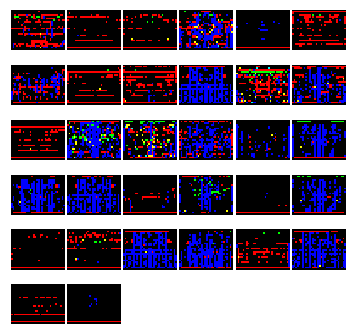

6 th evolution, score_max:1.0, score_min:0.1062,
[0.30779231 0.97600361 0.12997013 1.0001     0.10616061 0.44786119
 0.94946709 0.86595366 1.0001     0.18082289 0.85403258 0.21062632
 0.8314253  0.55706203 0.22378421 1.0001     0.91576265 0.92763623
 0.98640137 0.3601     0.94881795 0.78323253 0.78323253 0.3751
 0.23621111 0.89715882 0.93680886 0.2751     0.23180732 0.95662174
 0.31954444 0.43845616]


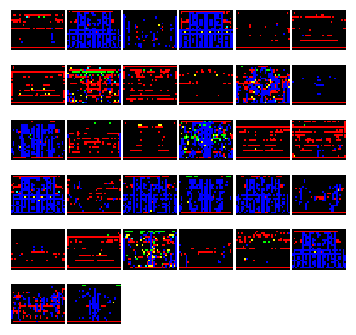

7 th evolution, score_max:1.0, score_min:0.1447,
[0.44328182 0.97540864 0.98911099 0.18319859 0.89343333 0.1885058
 0.84820127 1.0001     0.87333944 0.44588313 0.765725   0.22867143
 0.91438571 0.9138931  1.0001     0.18898889 0.93452623 0.93065556
 0.96373636 0.7501     0.45843333 0.23297671 0.86756988 0.91576265
 0.15724286 0.39715882 0.34676667 0.81588947 0.95248095 0.84517042
 0.21927808 0.14467831]


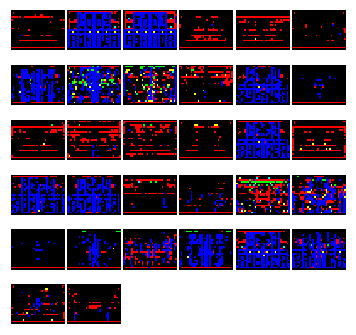

8 th evolution, score_max:1.0, score_min:0.1766,
[0.93065556 1.0001     0.25651026 0.96212532 0.80242558 0.97378421
 1.0001     0.8751     0.78833529 0.98370656 0.92547313 0.86429753
 0.98560725 1.0001     1.0001     0.56174384 0.87664321 0.89421765
 0.34676667 0.93680886 0.8751     0.85084627 0.25935926 0.17657059
 0.87366322 0.8301     0.19746842 1.0001     0.32404366 0.2501
 0.26163846 0.55394615]


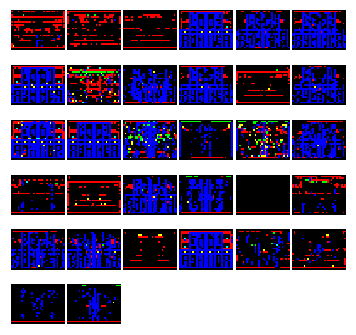

9 th evolution, score_max:1.0, score_min:0.08706,
[1.0001     0.77343333 1.0001     0.08705652 0.94946709 0.98517463
 1.0001     0.97024925 0.91438571 0.2501     0.77037027 0.87847838
 0.98601549 0.8359209  0.84454444 1.0001     0.84156341 0.97570976
 1.0001     0.92317692 1.0001     0.81828182 0.95532388 0.87189487
 0.2001     1.0001     0.77282727 0.1126     0.95532388 0.20789221
 0.18431053 0.28745632]


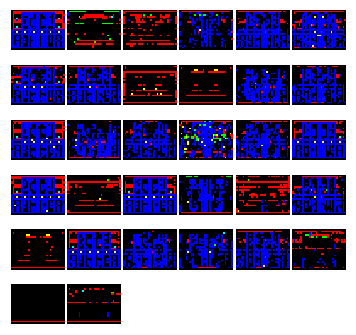

epoch: 1 ,conclusion
raw population


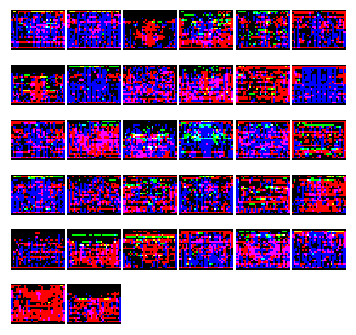

final image


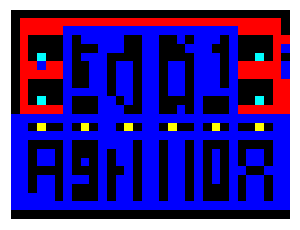

final population


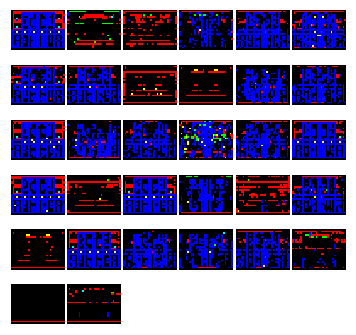

epoch: 2 ,start----------------------------------------------


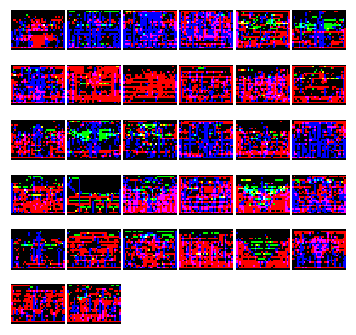

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.0126,
[0.75913614 0.65863659 0.98833529 0.14644146 0.64207531 0.66676667
 0.45464545 0.68503151 0.76414494 0.25935926 0.578225   1.0001
 0.12205122 0.98640137 0.69024085 0.62131212 0.02749726 0.16676667
 0.6251     0.16893117 0.8626     0.31470674 0.2001     0.16448356
 0.40253902 0.08460704 0.08118108 0.32333232 0.04064054 0.11774706
 0.01622903 0.0126    ]
1 th evolution, score_max:1.0, score_min:0.04504,
[0.72473768 0.93343333 0.2376     0.58833529 0.75352466 0.70598235
 1.0001     0.3751     0.04504382 0.77904737 0.98640137 0.24295714
 0.15264237 0.37219302 0.22590645 0.7033967  0.40253902 0.26605745
 1.0001     0.28581429 0.55233881 1.0001     0.59100909 0.62972963
 0.54746842 1.0001     0.2801     0.23621111 0.72378421 0.11852105
 0.16959153 0.54804521]


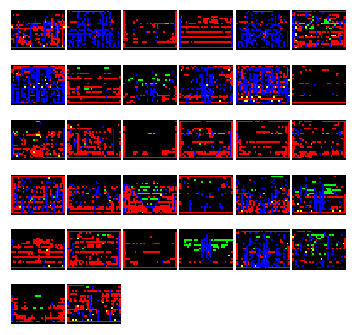

2 th evolution, score_max:1.0, score_min:0.0751,
[0.64644146 0.2376     0.72867143 0.45080423 0.59149785 0.93516494
 0.14295714 1.0001     0.28245294 0.57841325 0.98833529 0.7876
 0.77282727 0.68503151 0.35221268 0.51622903 0.13963488 0.98898889
 0.25685676 1.0001     0.31178831 0.08055977 1.0001     0.72174948
 0.27546232 0.9048619  0.0751     0.52787778 0.98539412 0.56531739
 0.17867143 0.54888049]


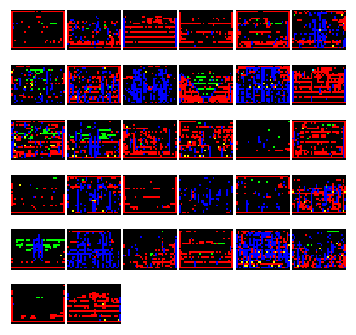

3 th evolution, score_max:1.0, score_min:0.02788,
[0.71062632 0.74035974 0.55082464 0.36373636 1.0001     1.0001
 0.83833529 0.28777123 0.98539412 0.26839268 0.47684419 0.26933077
 0.72423793 0.02787778 0.97600361 0.50627284 0.66186471 0.15199873
 0.57585758 1.0001     0.88471538 0.68637451 0.32477532 0.98711299
 1.0001     0.75685676 0.65527241 0.29860746 0.20905522 0.296975
 1.0001     1.0001    ]


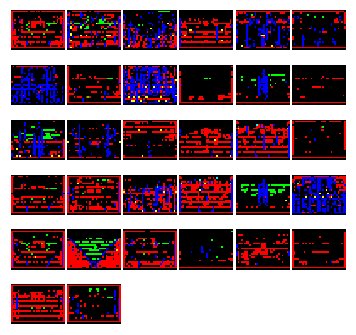

4 th evolution, score_max:1.0, score_min:0.0598,
[0.69328182 0.71631622 0.7501     0.36496486 0.98727949 1.0001
 1.0001     0.22629048 0.93431053 0.7038037  0.93113448 0.15724286
 0.75767576 0.73086923 0.2001     0.72423793 0.66302135 0.06676667
 0.7030703  0.53174557 0.92967746 0.39516173 0.74586271 0.05980149
 0.77429355 1.0001     1.0001     0.58451558 0.96731311 0.33717865
 0.33343333 1.0001    ]


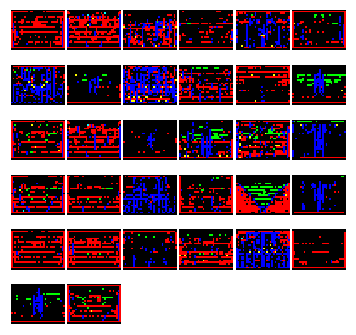

5 th evolution, score_max:1.0, score_min:0.1572,
[1.0001     0.98581429 0.62347662 0.98860575 1.0001     1.0001
 0.82904737 0.55431687 0.21136761 0.70779231 0.68431053 0.83343333
 0.48727949 0.75872069 1.0001     0.31335301 0.79601837 0.74334324
 0.84820127 0.74084074 0.91368025 0.4376     1.0001     0.17657059
 1.0001     0.23198406 0.97600361 1.0001     0.8876     0.15724286
 0.69873014 0.53531127]


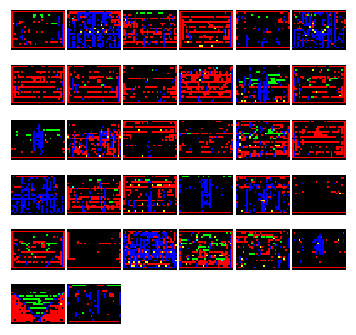

6 th evolution, score_max:1.0, score_min:0.1409,
[0.14094507 0.8751     1.0001     0.8314253  0.67020309 0.62931348
 0.6057338  0.23694211 0.65227391 0.22676667 0.17317692 0.93516494
 0.69522195 0.8001     0.97193099 0.57657059 0.87847838 1.0001
 0.15967447 0.97232222 0.44096022 0.87106774 0.79528072 0.46163846
 0.33343333 0.36629718 0.79022346 0.35493871 1.0001     0.67958718
 1.0001     1.0001    ]


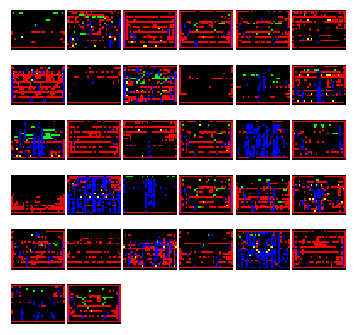

7 th evolution, score_max:1.0, score_min:0.08245,
[1.0001     0.68841169 0.98255614 0.7601     0.95724286 1.0001
 1.0001     0.98819524 0.91186471 0.22737273 0.81438571 0.21062632
 0.72232222 0.93431053 0.77037027 0.24685325 0.64483684 0.7601
 0.26037397 0.37219302 0.95358837 0.65527241 0.45987011 0.71438571
 0.94815195 0.4876     0.80622245 0.1687747  0.08245294 0.24334324
 0.31676667 0.85517246]


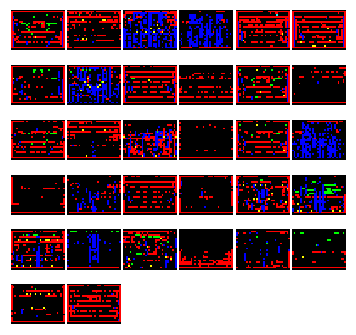

8 th evolution, score_max:1.0, score_min:0.1668,
[0.77951176 0.97152857 0.75685676 0.97068824 1.0001     0.81676667
 0.64945065 0.72299157 0.33793784 0.93694211 0.64295714 0.2174913
 0.53498372 0.9501     0.23953662 0.66186471 1.0001     0.92483118
 0.97478354 0.88321688 0.50659351 1.0001     0.62676667 0.71708113
 0.16676667 0.76480588 0.20557945 1.0001     0.52712703 0.50584713
 0.98833529 0.98422698]


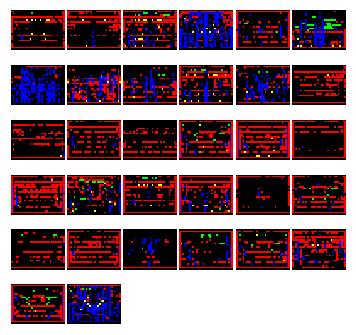

9 th evolution, score_max:1.0, score_min:0.1906,
[0.2963963  0.47232222 1.0001     0.69127647 0.19057619 0.54226867
 0.98775432 0.62676667 1.0001     0.63245294 0.55138205 0.68125942
 0.77037027 0.28777123 0.7376     0.47897324 0.92434242 0.9501
 0.86056512 0.55082464 1.0001     0.22998506 0.30444783 1.0001
 0.92115263 0.98694211 1.0001     0.27390952 0.97445897 0.78797879
 0.203225   0.92115263]


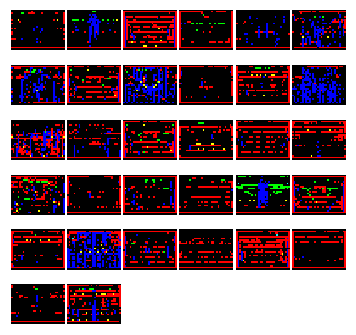

epoch: 2 ,conclusion
raw population


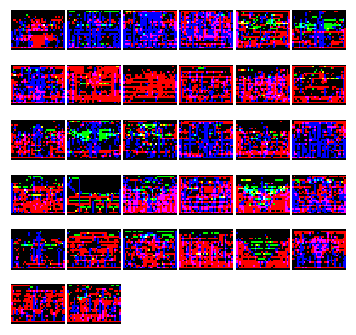

final image


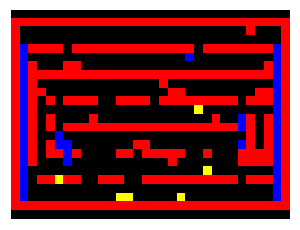

final population


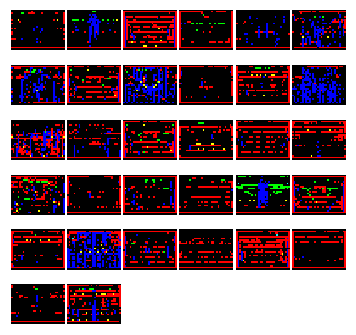

epoch: 3 ,start----------------------------------------------


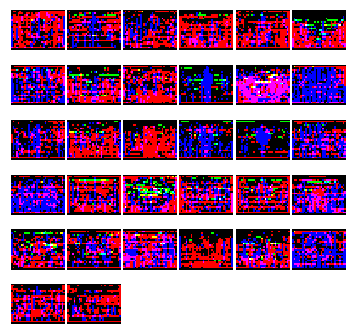

(10000, 24, 32, 5)
0 th evolution, score_max:0.9887, score_min:0.01418,
[0.9201     0.81491481 0.75372319 0.74368974 0.7126     0.98873636
 0.30146986 0.39140435 0.84156341 0.50584713 0.22087922 0.8251
 0.7196122  0.69630253 0.47068824 0.28405062 0.61637907 0.38564217
 0.14094507 0.91964023 0.32333232 0.31878132 0.12205122 0.26200476
 0.03856154 0.5001     0.30779231 0.07152857 0.05724286 0.10179492
 0.02712703 0.01418451]
1 th evolution, score_max:1.0, score_min:0.1001,
[0.1001     0.87068824 0.81438571 0.90676667 0.5876     0.85724286
 0.28995507 0.2501     1.0001     0.56954444 1.0001     0.8314253
 0.15883016 0.40516329 0.92781084 0.76414494 0.15799474 0.20699655
 1.0001     0.24400244 0.7028027  0.91588947 0.63646364 0.24667534
 0.70501803 0.51172791 1.0001     0.36154578 0.73694211 0.41473415
 0.18191818 0.2346679 ]


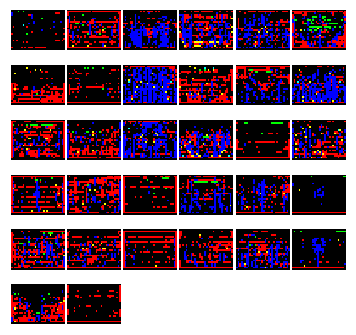

2 th evolution, score_max:1.0, score_min:0.07327,
[0.86450678 0.5001     0.1370863  0.98934731 0.7126     0.23386623
 1.0001     1.0001     0.77787778 0.51292051 0.81491481 0.75619756
 0.36373636 0.3259427  0.85879565 0.68684699 0.88321688 0.14483684
 0.42867143 0.27390952 0.07327073 0.83126883 0.2201     0.4048619
 0.86216897 0.17592418 0.2196122  0.22423793 0.24106386 0.27787778
 0.83086923 0.94454444]


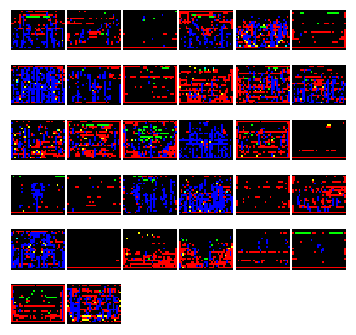

3 th evolution, score_max:1.0, score_min:0.0626,
[0.25724286 1.0001     0.7261274  0.51096957 1.0001     0.18833529
 0.1876     0.30146986 0.64112564 0.82442432 0.38245294 1.0001
 0.34792609 0.24647681 0.84858485 0.0626     1.0001     0.29587465
 0.25326456 0.71438571 0.2801     0.5001     0.31091081 0.81491481
 0.12951176 0.56726418 0.12997013 0.078225   0.89343333 0.16676667
 0.82676667 0.74693544]


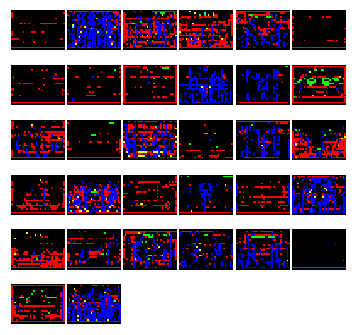

4 th evolution, score_max:1.0, score_min:0.1472,
[0.96979697 0.55706203 0.77152857 0.19287108 0.89421765 0.6401
 0.41035641 1.0001     0.46163846 0.8962039  0.5251     1.0001
 0.46278657 0.25619756 0.92967746 0.84067971 1.0001     0.86914762
 0.38971039 0.20997654 0.22087922 0.36629718 0.81700141 0.24060633
 0.8453381  0.81343333 0.75959367 0.21927808 0.30273158 0.18431053
 0.15863659 0.14715882]


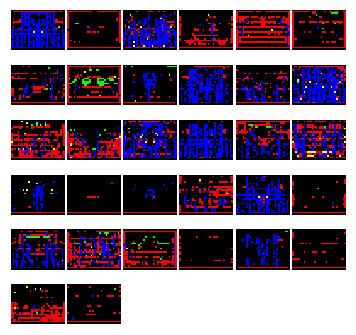

5 th evolution, score_max:1.0, score_min:0.1068,
[0.14127647 0.87702308 0.21186471 0.9251     0.3751     0.10676667
 1.0001     0.5001     0.18302683 0.49448202 0.91407849 0.79042258
 0.97378421 1.0001     0.94815195 0.96480588 0.18343333 0.88321688
 0.13898889 0.19287108 1.0001     0.2126     0.77037027 0.32921392
 0.11698312 0.82936829 0.11300323 0.18319859 0.17115263 0.20843333
 0.18928919 0.3751    ]


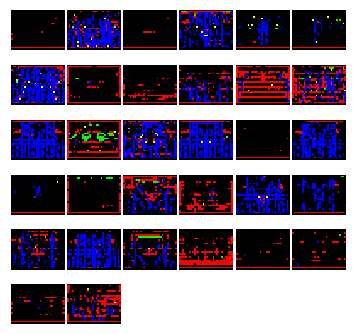

6 th evolution, score_max:1.0, score_min:0.1482,
[0.17401304 1.0001     0.26839268 0.17401304 0.27282727 0.77390952
 1.0001     0.37888788 0.77641579 0.45215479 0.92763623 0.1628907
 0.91535424 0.19127647 0.97111449 0.87681233 0.25591395 0.37847838
 0.88069701 0.92763623 0.14824815 0.7751     0.19617843 0.8376
 1.0001     0.53256753 0.97684419 0.98397097 0.34577901 0.98711299
 0.24295714 0.83526484]


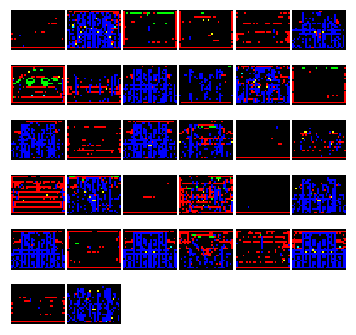

7 th evolution, score_max:1.0, score_min:0.1001,
[1.0001     0.41782152 0.1642791  0.82618696 0.67098608 1.0001
 0.15264237 0.84067971 0.38038169 0.88245294 0.38105238 0.98744177
 0.7501     0.97412597 0.84820127 0.5376     0.78491013 0.13167895
 0.9601     0.97412597 0.1828957  0.17055455 0.83938571 0.23086923
 0.98819524 0.29343333 0.38581429 0.12058193 0.81022658 0.24252424
 0.94057619 0.1001    ]


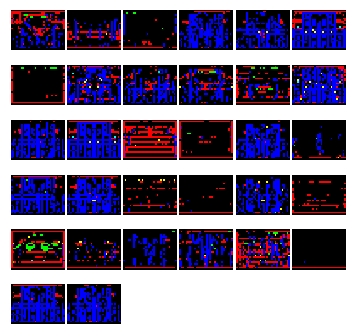

8 th evolution, score_max:1.0, score_min:0.06677,
[0.94746842 1.0001     0.92217792 1.0001     0.80497805 1.0001
 0.8116942  0.97343333 1.0001     0.10598235 0.30146986 0.98601549
 0.8626     0.85343333 0.13803103 0.96561724 0.73025873 0.84220526
 0.95190723 0.14295714 0.72378421 0.10676667 1.0001     0.96212532
 0.43383494 0.06676667 0.89562239 0.40919091 0.19364839 0.93431053
 0.26398889 0.64874865]


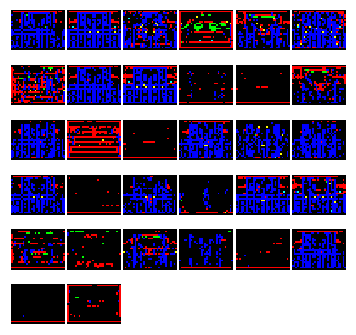

9 th evolution, score_max:1.0, score_min:0.04555,
[0.20940233 0.8029169  1.0001     0.9001     0.95394615 0.91407849
 0.94196047 0.9751     0.98397097 0.04555455 0.24368974 0.92217792
 0.58833529 0.74035974 1.0001     0.9201     1.0001     0.8751
 1.0001     0.95724286 0.97193099 0.88774045 0.3751     0.79176667
 1.0001     0.1876     0.46676667 1.0001     0.95598235 1.0001
 0.1601     0.29278293]


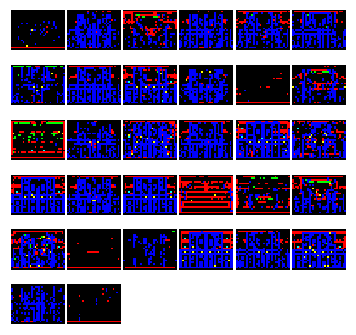

epoch: 3 ,conclusion
raw population


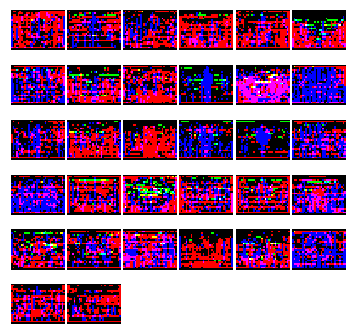

final image


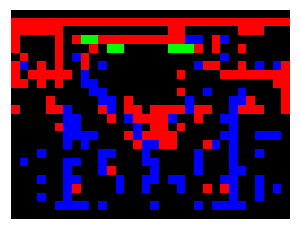

final population


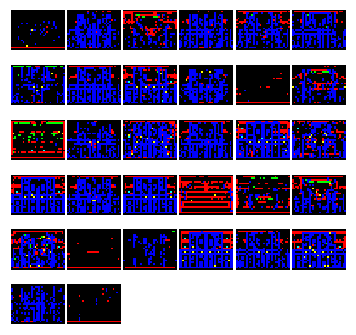

epoch: 4 ,start----------------------------------------------


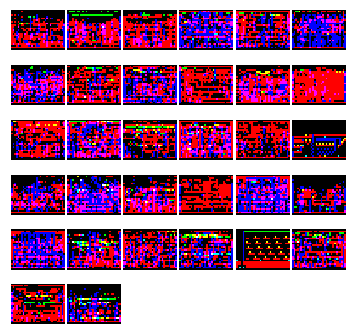

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.01292,
[1.0001     0.34256575 0.8626     0.81619195 0.79022346 0.96163846
 0.8126     0.04064054 0.01308701 0.75334675 1.0001     0.97232222
 0.19364839 0.03581429 0.71920112 0.3626     1.0001     0.2401
 0.50659351 0.71094337 0.51361351 0.84755763 0.4251     0.54804521
 0.22629048 0.2501     0.0626     0.10598235 0.02419639 0.09220526
 0.01292051 0.03624458]
1 th evolution, score_max:1.0, score_min:0.02449,
[0.97684419 0.06954444 1.0001     0.82964545 0.74722644 0.82362941
 0.82988723 0.07068824 0.22545211 1.0001     0.3751     0.97024925
 1.0001     0.41676667 0.76933077 0.91186471 0.9876     0.03807468
 0.2346679  0.53856154 0.62676667 0.6120403  0.19127647 0.02908551
 0.21828182 0.73819524 0.07327073 0.02449024 0.96784194 0.12997013
 0.23086923 0.5001    ]


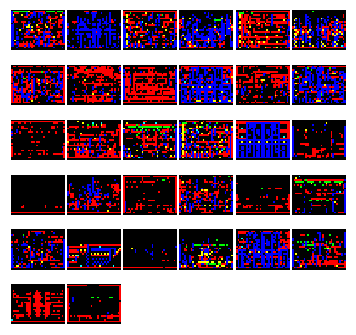

2 th evolution, score_max:1.0, score_min:0.07069,
[0.09469459 0.86595366 0.98471538 0.89051096 0.98601549 1.0001
 0.07068824 0.22378421 0.23694211 0.46676667 0.97270274 0.97570976
 0.44057619 0.21438571 1.0001     0.11373636 0.24667534 0.83343333
 0.11402405 1.0001     0.9876     1.0001     0.72629048 1.0001
 0.53957368 0.61455783 0.60724286 0.11277606 0.83571644 1.0001
 0.79720145 1.0001    ]


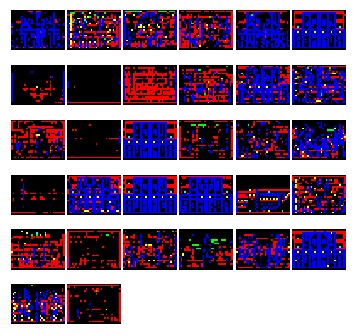

3 th evolution, score_max:1.0, score_min:0.08871,
[0.9626     0.91901892 1.0001     0.45987011 0.96062632 1.0001
 0.64295714 0.98370656 0.98694211 0.98676667 0.82676667 1.0001
 0.08870759 0.17577568 0.90253902 0.8626     0.98601549 0.23297671
 1.0001     1.0001     0.65681642 0.15502958 1.0001     0.18400805
 0.80831918 0.09100909 1.0001     1.0001     1.0001     0.75685676
 0.8401     0.50694932]


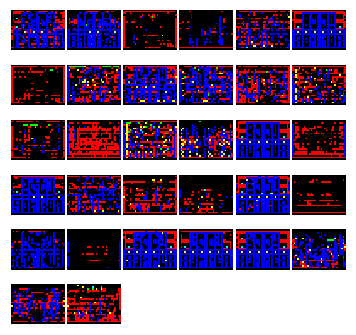

4 th evolution, score_max:1.0, score_min:0.06677,
[1.0001     0.65394615 0.98621111 0.60879565 0.29240769 0.31516849
 0.93516494 0.86852105 0.82061282 0.34156341 1.0001     1.0001
 0.97412597 1.0001     0.25383134 0.86595366 0.9251     0.96818511
 1.0001     0.25343333 1.0001     1.0001     0.06676667 0.16911408
 1.0001     0.54661163 1.0001     1.0001     0.16059383 0.8962039
 1.0001     1.0001    ]


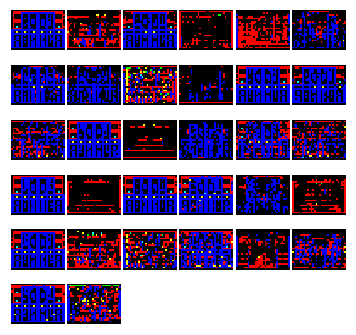

5 th evolution, score_max:1.0, score_min:0.149,
[1.0001     0.9626     1.0001     1.0001     1.0001     0.31091081
 0.6001     1.0001     1.0001     0.73694211 0.94604595 1.0001
 1.0001     0.14903617 0.98744177 0.92547313 1.0001     0.84625385
 0.83343333 0.62328841 0.76933077 1.0001     1.0001     0.24060633
 0.38719677 1.0001     1.0001     1.0001     0.87022987 0.97600361
 0.95071728 0.59503671]


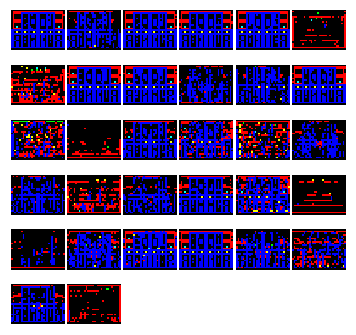

6 th evolution, score_max:1.0, score_min:0.1832,
[0.97412597 1.0001     1.0001     1.0001     0.94515495 1.0001
 1.0001     1.0001     1.0001     0.9376     0.98873636 0.98711299
 0.85724286 1.0001     1.0001     0.859475   1.0001     0.98805181
 1.0001     0.60820811 0.94946709 1.0001     1.0001     0.8989764
 0.83343333 0.90150845 0.9751     1.0001     0.70522821 0.33343333
 0.18319859 0.77343333]


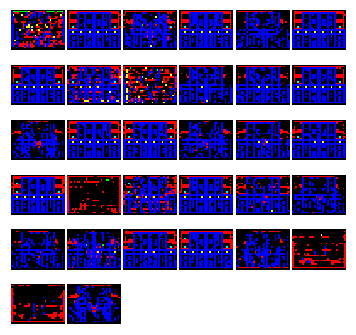

7 th evolution, score_max:1.0, score_min:0.1782,
[0.9251     1.0001     1.0001     1.0001     1.0001     0.98621111
 1.0001     1.0001     0.98957368 0.97111449 1.0001     1.0001
 0.28215128 1.0001     1.0001     1.0001     0.98694211 1.0001
 1.0001     0.71885    0.98621111 1.0001     1.0001     0.17818219
 0.71222121 0.953225   1.0001     0.96676667 0.86676667 0.8751
 0.95532388 0.62131212]


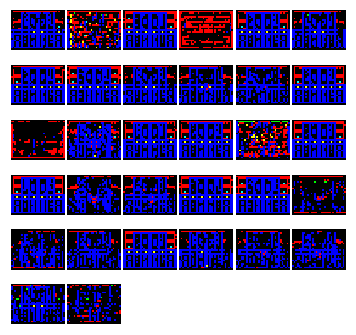

8 th evolution, score_max:1.0, score_min:0.08229,
[1.0001     0.79555455 0.90371446 0.57702308 1.0001     0.98621111
 1.0001     1.0001     1.0001     1.0001     0.91901892 0.74295714
 1.0001     1.0001     1.0001     0.9601     1.0001     0.2001
 0.2501     1.0001     0.94925254 0.9201     1.0001     0.98471538
 1.0001     0.08229178 1.0001     0.9376     1.0001     1.0001
 0.95565556 1.0001    ]


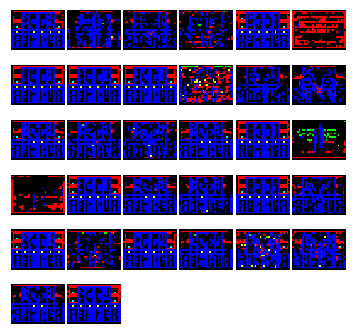

9 th evolution, score_max:1.0, score_min:0.2309,
[0.98621111 0.58833529 0.90550541 1.0001     0.78957368 0.32951176
 0.93488261 0.95708925 1.0001     0.77787778 1.0001     0.96639213
 0.97684419 0.92867143 1.0001     1.0001     0.92232222 1.0001
 1.0001     0.98860575 0.23086923 0.9048619  1.0001     0.96561724
 1.0001     0.78957368 1.0001     1.0001     1.0001     0.98873636
 0.359475   1.0001    ]


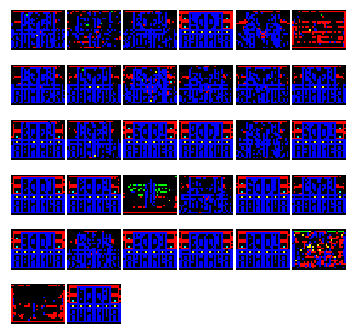

epoch: 4 ,conclusion
raw population


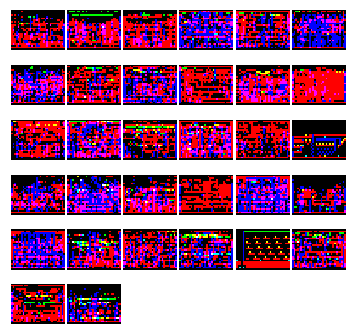

final image


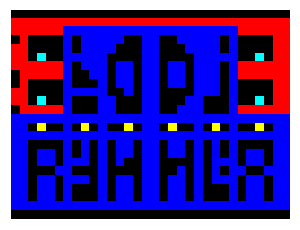

final population


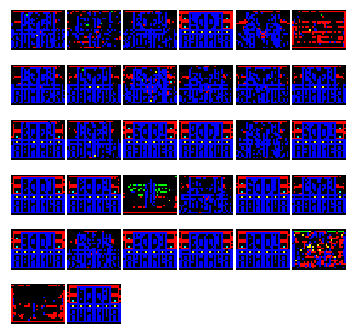

epoch: 5 ,start----------------------------------------------


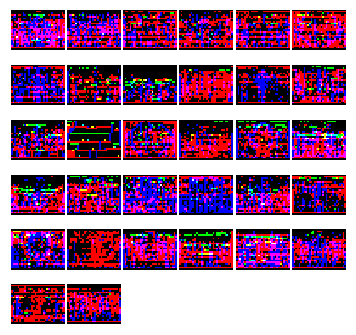

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.01097,
[0.7601     0.86895246 0.71094337 0.70843333 0.62362941 0.32108765
 0.34732222 0.47897324 0.95190723 0.64377816 1.0001     0.78419091
 0.91964023 0.6626     0.43845616 0.12867143 0.17731519 0.89240769
 0.20741707 0.09343333 0.85724286 0.1972831  0.38833529 0.41801045
 0.03624458 0.5501     0.01096957 0.08460704 0.11121111 0.20997654
 0.07604937 0.01502537]
1 th evolution, score_max:1.0, score_min:0.01481,
[0.7722519  0.4626     0.46488873 1.0001     0.71631622 0.77787778
 0.48061948 0.57544247 0.34577901 0.07417407 0.75651026 0.27282727
 0.54330988 0.86595366 0.88245294 0.20248095 0.85517246 0.69672921
 0.19240769 0.5001     0.82904737 0.08118108 0.8626     0.02449024
 0.52574103 0.5251     0.14676667 0.37691159 0.35304118 0.33343333
 0.19287108 0.01480588]


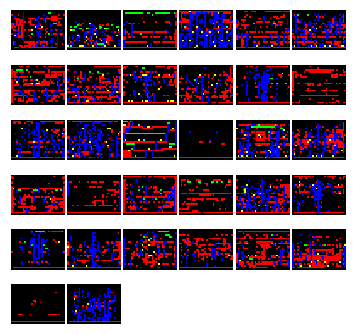

2 th evolution, score_max:1.0, score_min:0.02542,
[0.07802208 0.05343333 0.12997013 0.8001     0.03646364 0.79176667
 0.63245294 0.86744694 0.19746842 0.21927808 0.86676667 0.28245294
 0.91035641 0.58343333 1.0001     0.02541646 0.62867143 0.76129403
 0.29771905 0.22782277 0.20843333 0.63646364 0.23890597 0.2184908
 0.90371446 0.5001     0.81954444 0.32921392 0.34676667 0.38105238
 0.38366164 0.54939577]


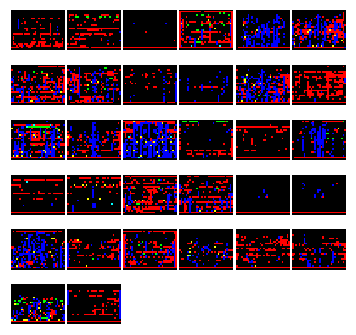

3 th evolution, score_max:1.0, score_min:0.08547,
[0.08546585 0.82768621 0.84347349 0.41782152 0.2126     0.30098496
 0.23621111 0.73819524 0.1751     0.61300323 0.61914762 0.22676667
 0.43191818 0.57981014 0.4001     0.70896076 0.29123924 0.13263012
 0.70598235 0.81700141 0.3501     1.0001     0.91314348 0.26839268
 0.49343333 0.2248191  0.30273158 0.23819524 0.66676667 0.28777123
 0.51398889 0.40516329]


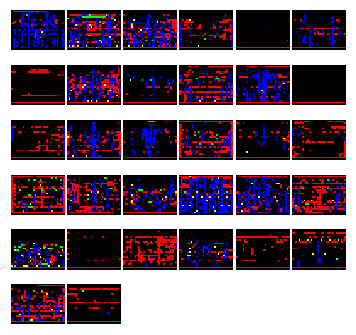

4 th evolution, score_max:1.0, score_min:0.1629,
[0.66676667 0.22676667 0.22087922 0.83833529 0.2501     0.390725
 0.62696567 1.0001     0.27390952 0.98640137 0.76480588 0.45131951
 0.7001     0.3876     0.9001     0.88689245 0.43383494 0.5001
 0.37088652 0.49360649 0.85724286 0.1628907  0.45248095 0.62328841
 0.6126     0.35375854 0.28405062 0.33812817 0.19763086 0.82152857
 0.5626     0.76281186]


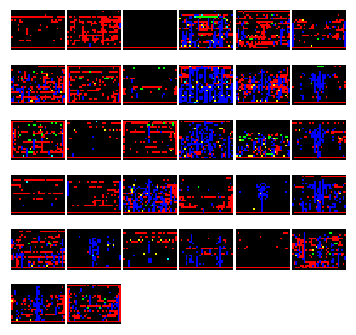

5 th evolution, score_max:1.0, score_min:0.1779,
[0.38382093 1.0001     0.26398889 0.46278657 0.2963963  0.57327073
 0.65161515 0.75394615 0.61438571 0.21438571 0.62035316 0.61914762
 0.86163846 0.82442432 0.64945065 0.81548462 0.17787778 0.8001
 0.39516173 0.31438571 0.85304118 0.70741707 1.0001     0.28777123
 0.46885    1.0001     0.30146986 0.91438571 0.52232222 0.98676667
 0.17958718 0.84941507]


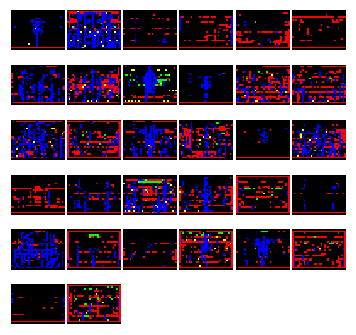

6 th evolution, score_max:1.0, score_min:0.05205,
[1.0001     0.86085949 0.75959367 0.77152857 1.0001     0.85145135
 0.65442099 0.54454444 1.0001     0.05204805 0.8853459  0.75767576
 0.50627284 0.46676667 0.24368974 0.74454444 0.8631137  0.54295714
 0.73043708 0.56480588 0.51908734 0.51096957 0.51292051 0.56766757
 0.71438571 0.14112564 0.11438571 0.23694211 0.13934051 0.85892353
 0.56070606 0.6876    ]


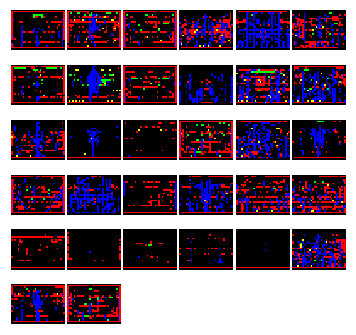

7 th evolution, score_max:1.0, score_min:0.139,
[0.78698525 0.56999247 0.73621111 0.72141148 0.82726049 0.8876
 0.21321475 1.0001     1.0001     0.20263165 0.78797879 0.20644921
 1.0001     0.65832785 0.77474789 0.23086923 0.86373636 0.27720843
 0.88128812 0.19746842 0.7376     0.58237848 0.13898889 0.79528072
 0.86852105 0.38581429 0.55724286 0.55706203 0.57343333 0.796975
 1.0001     0.55431687]


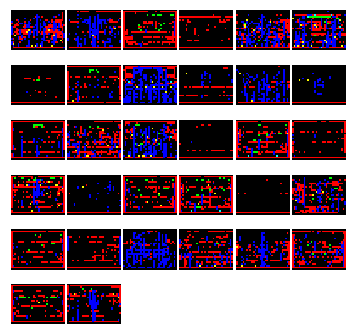

8 th evolution, score_max:1.0, score_min:0.1468,
[0.78092192 1.0001     0.37984684 0.80908876 0.62830513 0.17293951
 0.84295714 0.82676667 0.42867143 1.0001     1.0001     0.63390282
 0.27390952 0.75724286 0.18581429 0.74295714 0.19746842 0.82618696
 0.27390952 0.17920448 0.80444783 0.65565556 0.23621111 0.14676667
 0.15394615 0.57362941 0.55706203 0.2376     0.75591395 0.19746842
 0.70124943 0.1745186 ]


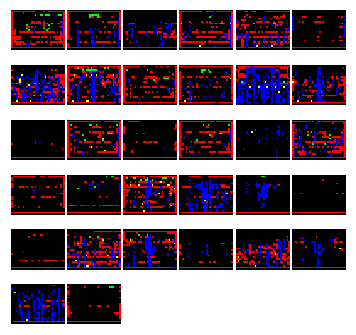

9 th evolution, score_max:1.0, score_min:0.09422,
[0.57152857 0.66243766 0.14483684 0.86774706 0.86085949 0.1972831
 0.89665172 0.71631622 0.55082464 0.87022987 0.70248095 0.2001
 0.62972963 0.2196122  0.7201     0.83554304 0.74084074 0.1370863
 0.7001     0.33343333 0.23242323 1.0001     0.18431053 0.09421765
 0.8001     0.14874865 0.12737273 0.14467831 0.21136761 0.6745186
 0.49325068 0.19287108]


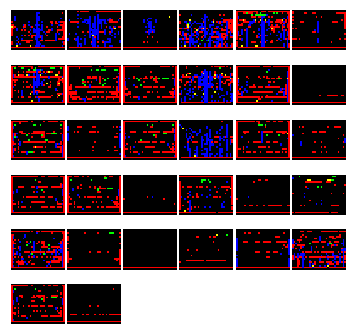

epoch: 5 ,conclusion
raw population


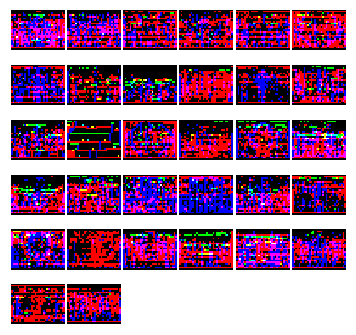

final image


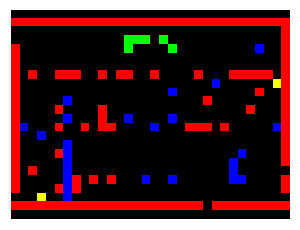

final population


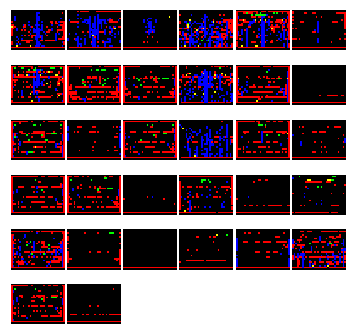

epoch: 6 ,start----------------------------------------------


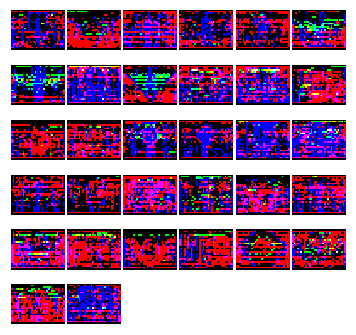

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.0001,
[9.17747059e-01 9.24150633e-01 6.44836842e-01 7.34277215e-01
 5.07346377e-01 2.02998551e-01 6.90240845e-01 7.25100000e-01
 2.67666667e-02 8.98834177e-01 1.00010000e+00 8.02731579e-01
 1.00010000e+00 1.94544444e-01 5.27315789e-02 7.03803704e-01
 1.78671429e-01 9.57846479e-01 8.53433333e-01 1.68639326e-01
 1.56726506e-01 1.55944156e-01 4.17821519e-01 6.38654217e-01
 5.00100000e-01 4.12600000e-01 2.68392683e-01 6.42025641e-02
 3.90610390e-02 1.78182192e-01 2.82690141e-02 1.00000000e-04]
1 th evolution, score_max:1.0, score_min:0.1291,
[0.7013987  1.0001     1.0001     0.34949759 0.37847838 0.42475753
 0.90133457 0.17055455 0.45464545 0.69421765 0.59732222 0.95358837
 0.86429753 0.7001     0.8359209  0.78581429 1.0001     0.21321475
 0.96480588 0.71438571 0.2001     0.7501     0.36373636 0.67542468
 0.15724286 0.76480588 0.29079767 0.12913226 0.39140435 0.32061282
 0.91576265 0.29771905]


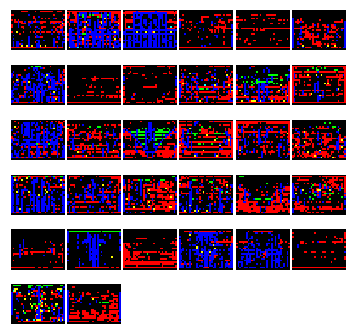

2 th evolution, score_max:1.0, score_min:0.1234,
[0.50756269 0.21186471 0.92602593 0.84941507 0.40799474 0.95955946
 0.66226216 0.6751     1.0001     0.7201     0.76398889 0.84715882
 0.21804872 0.12338767 0.35097719 0.30389747 0.67133288 0.37189487
 0.96306296 0.91035641 0.6751     0.34676667 0.73621111 0.42115263
 0.52951176 0.36595366 0.67282727 0.18319859 0.53856154 0.19240769
 0.34577901 0.40287778]


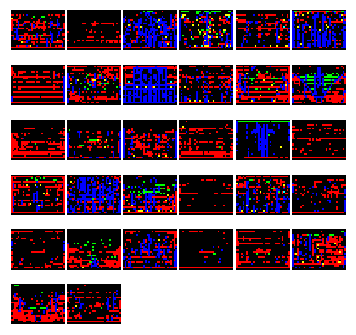

3 th evolution, score_max:0.9885, score_min:0.1126,
[0.41985309 0.71631622 0.29343333 0.77916977 0.89883418 0.50659351
 0.74636866 0.22545211 0.30444783 0.93191818 0.77932078 0.42115263
 0.91438571 0.3601     0.64798732 0.62232222 0.90598235 0.24647681
 0.98847209 0.78797879 0.92602593 0.45343333 0.64295714 0.6876
 0.55854156 0.59469459 0.14616742 0.75318642 0.52122676 0.68065556
 0.29895057 0.1126    ]


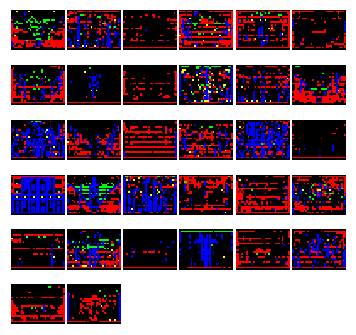

4 th evolution, score_max:1.0, score_min:0.05415,
[0.19746842 0.36517937 1.0001     0.67115263 0.9048619  0.69746842
 1.0001     0.90332581 0.13167895 1.0001     0.7028027  0.7196122
 0.70843333 0.36595366 0.93065556 0.54032989 0.734475   0.61548462
 0.41473415 0.51292051 0.90435532 1.0001     0.70779231 0.76754186
 0.11852105 0.24685325 0.3126     0.49343333 0.96212532 0.1626
 0.24060633 0.05415405]


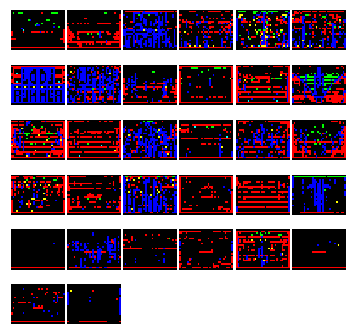

5 th evolution, score_max:1.0, score_min:0.05489,
[0.2626     1.0001     0.7501     0.73144328 0.18997342 0.20263165
 0.69364839 0.61738395 0.47836087 0.37343333 0.32886712 1.0001
 0.80831918 0.77282727 0.05489452 0.26037397 0.96062632 1.0001
 0.93856154 0.1251     0.7251     0.91314348 0.1628907  0.20522821
 0.77951176 0.22232222 0.52232222 0.3251     0.52183913 0.98727949
 0.94746842 0.27951176]


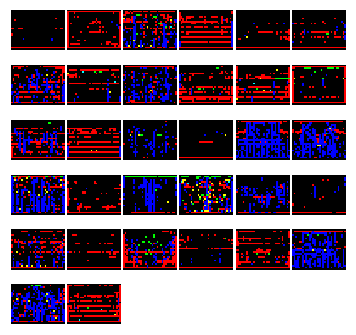

6 th evolution, score_max:1.0, score_min:0.04948,
[0.77118434 0.50627284 1.0001     0.92793505 0.54804521 0.21600909
 0.23539412 0.77037027 0.5916493  0.75334675 1.0001     0.96212532
 0.64715882 0.77951176 1.0001     0.6801     0.29771905 0.28925663
 0.23180732 0.04948272 0.89421765 0.08546585 0.24334324 0.7655321
 0.58471538 0.05627978 0.73265814 0.27720843 0.14467831 0.58237848
 0.48727949 0.15394615]


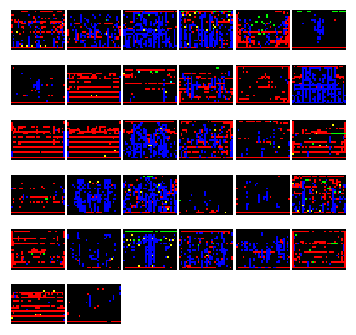

7 th evolution, score_max:1.0, score_min:0.1287,
[0.59220526 0.50642911 0.390725   0.92781084 0.1876     0.98601549
 0.28581429 0.24715882 0.21885    0.98727949 0.59766098 0.4026974
 0.73694211 0.18581429 0.67133288 0.68065556 0.4501     0.64798732
 0.44625385 0.16676667 1.0001     0.2001     0.77118434 0.2988013
 0.83793784 0.12867143 1.0001     0.70896076 0.15672651 0.62867143
 0.74676667 0.40799474]


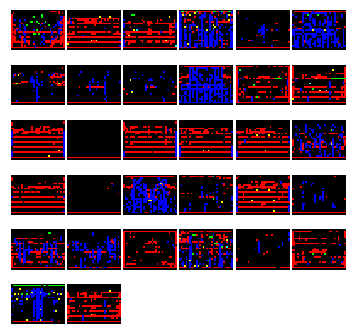

8 th evolution, score_max:1.0, score_min:0.04829,
[0.91676667 1.0001     0.20741707 0.96163846 0.63245294 0.52818989
 0.69240769 0.7001     1.0001     0.63424634 1.0001     0.70522821
 0.6251     0.04829277 0.27390952 0.2001     0.64393562 0.36373636
 0.6120403  0.40919091 0.36996301 0.5891411  0.51229512 0.81588947
 0.62035316 0.98539412 0.56331839 0.67958718 0.2001     1.0001
 0.2174913  0.15635   ]


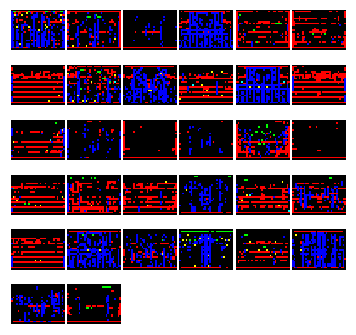

9 th evolution, score_max:1.0, score_min:0.06108,
[0.81186471 0.27170494 0.2126     0.18302683 0.14526129 0.94946709
 0.75334675 0.71614938 0.98847209 0.74657887 0.8031303  0.52183913
 1.0001     0.95565556 0.31405349 0.65832785 0.45843333 0.74295714
 0.51200476 0.53633188 0.97111449 0.68841169 0.19763086 0.59584468
 0.59503671 0.09599041 0.90919091 0.82904737 0.4026974  0.06107561
 0.06766757 0.54804521]


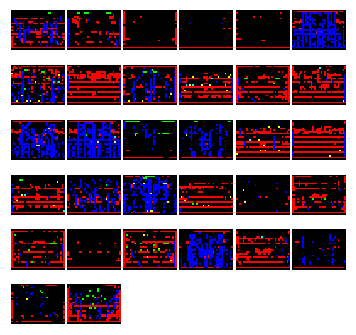

epoch: 6 ,conclusion
raw population


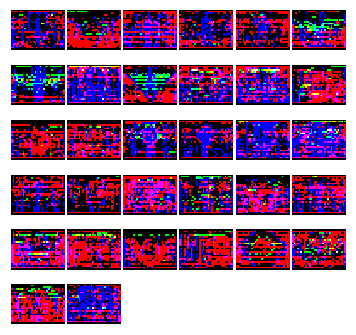

final image


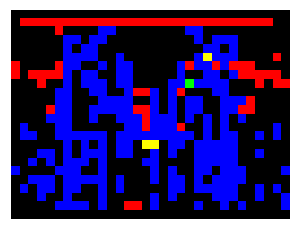

final population


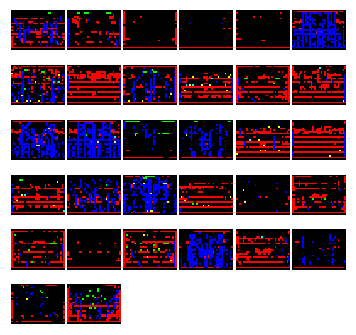

epoch: 7 ,start----------------------------------------------


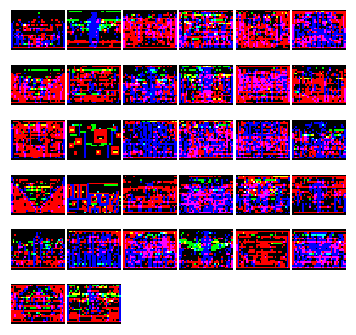

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.01361,
[0.81343333 0.98640137 0.7601     0.33343333 0.87961807 0.49460549
 0.68503151 0.78676667 0.7376     0.7722519  0.56348028 1.0001
 0.86429753 0.72737273 1.0001     0.28995507 0.15594416 0.58343333
 0.68191818 0.18928919 0.23873636 0.61852105 0.08651975 0.34127647
 0.2346679  0.36373636 0.52574103 0.1001     0.08118108 0.01361351
 0.04295714 0.05643803]
1 th evolution, score_max:1.0, score_min:0.03624,
[1.0001     0.29421765 0.68666716 0.33812817 0.98621111 0.64798732
 0.90550541 0.64189104 0.60879565 0.84156341 0.15502958 0.1001
 0.71651791 1.0001     0.81954444 0.68191818 0.66325789 1.0001
 0.34385    0.24600164 0.88898889 0.36996301 0.25297356 0.25362113
 0.42538736 0.04119589 0.72867143 0.86914762 1.0001     0.03624458
 0.85536316 0.3443623 ]


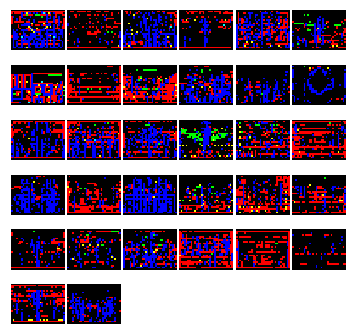

2 th evolution, score_max:1.0, score_min:0.1563,
[0.34256575 0.34732222 0.95190723 1.0001     0.48819524 0.71631622
 0.90676667 0.54295714 0.58436966 0.89166627 1.0001     0.38581429
 0.22232222 0.15635    0.18191818 0.56174384 0.19490519 0.46163846
 1.0001     0.46278657 0.60724286 0.2401     1.0001     0.83108592
 0.89865072 0.8251     0.23198406 0.43688161 0.18928919 0.50676667
 0.84425584 0.8601    ]


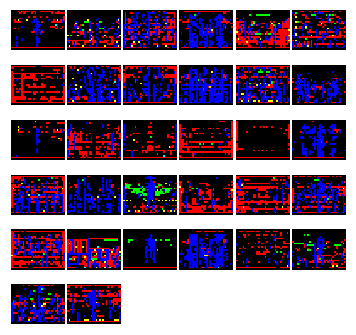

3 th evolution, score_max:1.0, score_min:0.05824,
[0.78833529 0.6120403  0.05823953 0.3376     1.0001     0.86496486
 0.51658352 0.98601549 0.2001     1.0001     0.34625385 0.52712703
 0.61548462 0.79375079 0.21631622 0.61738395 0.17657059 0.72737273
 0.89483684 0.98744177 0.87351772 0.96062632 0.5001     0.7028027
 0.21631622 1.0001     0.54771905 0.67577568 0.77787778 0.86676667
 0.17867143 0.70522821]


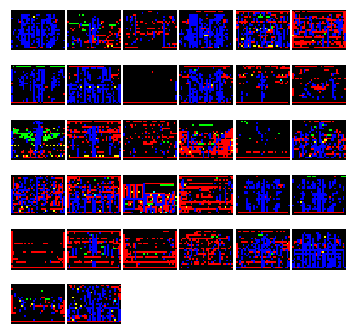

4 th evolution, score_max:1.0, score_min:0.1185,
[0.94212899 1.0001     0.78215128 0.64112564 0.4001     0.64454444
 0.93516494 0.32904737 0.25651026 0.80444783 0.29421765 0.86756988
 0.53633188 0.98873636 0.33776234 0.91559296 0.2401     0.86496486
 0.36056512 0.44937536 0.88898889 1.0001     1.0001     0.13646364
 0.20557945 0.93416593 0.95724286 0.85724286 0.515725   0.25984026
 0.57841325 0.11852105]


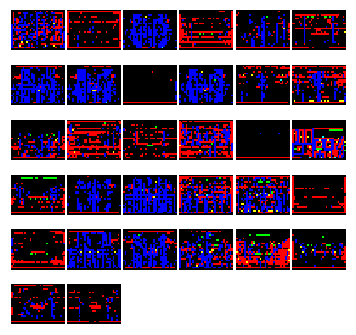

5 th evolution, score_max:1.0, score_min:0.04177,
[0.86676667 0.93660794 0.81343333 1.0001     0.97378421 1.0001
 0.21438571 0.2805878  1.0001     0.93488261 0.86914762 0.17958718
 0.75591395 0.65161515 0.7201     0.92951176 0.79230779 0.97270274
 0.09846066 0.83343333 0.90676667 0.9123807  0.59687419 0.04176667
 0.36373636 1.0001     0.44240769 0.19111124 0.97378421 0.3751
 0.26096957 0.98805181]


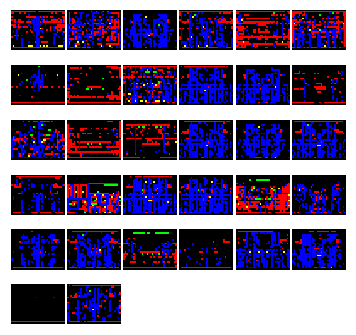

6 th evolution, score_max:1.0, score_min:0.2433,
[0.84732222 0.98775432 0.96351463 0.9601     0.89199189 0.45892353
 0.88053478 0.91576265 0.77951176 1.0001     0.86756988 0.89715882
 1.0001     0.78957368 0.63646364 0.9876     0.49305775 0.96885
 0.95724286 0.33343333 0.98676667 0.80565556 0.67133288 0.54064054
 0.87922088 0.91790822 0.89199189 0.86676667 0.92692927 1.0001
 0.78797879 0.24334324]


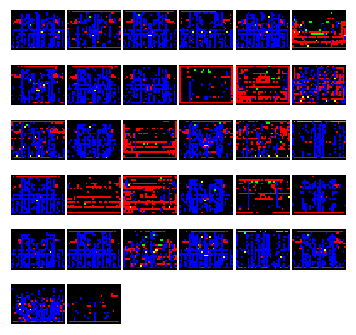

7 th evolution, score_max:1.0, score_min:0.1782,
[1.0001     0.98601549 0.92317692 0.81062632 0.68191818 0.80529481
 0.1970697  0.93680886 0.98676667 1.0001     1.0001     0.43047975
 1.0001     0.35907436 0.91407849 0.84492759 0.47378421 0.8126
 0.17818219 0.55854156 0.93516494 0.9001     1.0001     0.83343333
 0.88471538 0.26592278 0.98886404 0.47629048 0.26096957 1.0001
 0.90253902 0.40919091]


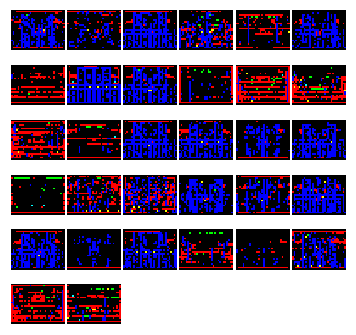

8 th evolution, score_max:1.0, score_min:0.104,
[0.75318642 0.93599744 1.0001     0.3453381  0.79114478 0.64798732
 0.92434242 0.76633377 0.34075934 0.35453038 0.98397097 0.91438571
 0.25343333 0.94746842 0.89421765 1.0001     0.1039961  0.36496486
 1.0001     0.97478354 0.36480588 0.52867143 0.4085507  1.0001
 0.94575217 1.0001     0.98860575 0.8876     0.93343333 0.87847838
 1.0001     0.47378421]


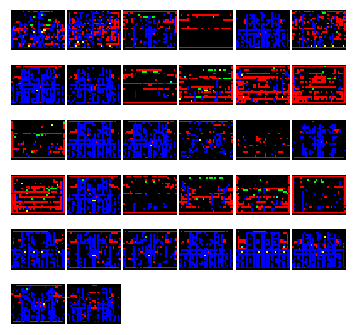

9 th evolution, score_max:1.0, score_min:0.04608,
[0.88145593 0.96373636 0.96885    0.80655161 0.36480588 1.0001
 0.73144328 0.88245294 0.80908876 0.77037027 0.9876     0.98744177
 0.22378421 0.96480588 1.0001     0.24428605 0.96351463 1.0001
 0.73982603 0.91790822 0.5001     0.26933077 0.34156341 0.84715882
 0.04607701 0.75352466 0.91676667 0.48898889 0.48727949 0.83108592
 1.0001     0.19364839]


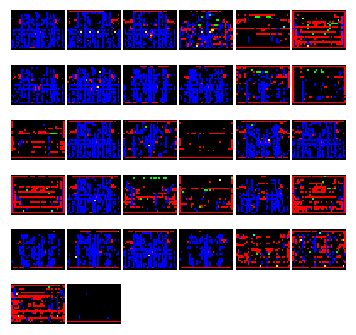

epoch: 7 ,conclusion
raw population


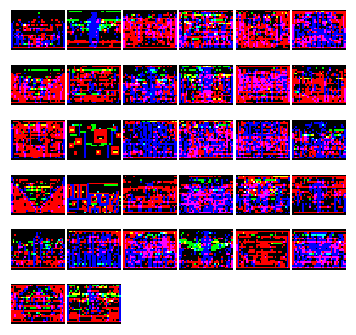

final image


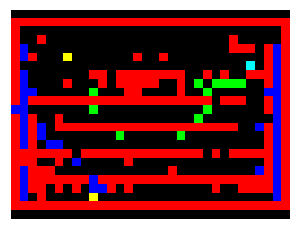

final population


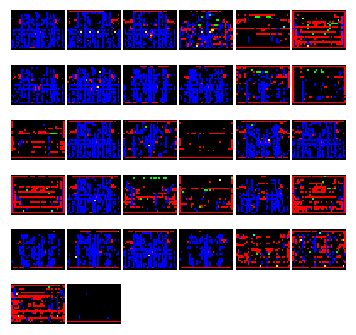

epoch: 8 ,start----------------------------------------------


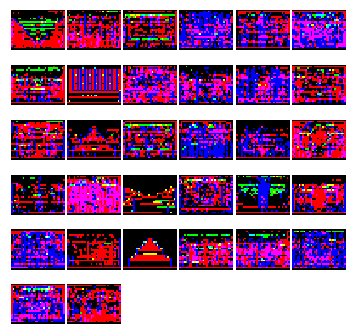

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.01326,
[0.91314348 0.77118434 0.49392716 0.94262874 1.0001     0.90799474
 1.0001     0.84792609 0.07327073 0.55565556 0.16448356 0.17920448
 0.03581429 1.0001     0.7001     0.4126     0.48790488 0.6251
 0.56189775 0.51398889 0.14644146 0.71774706 0.28215128 0.13424634
 0.15799474 0.2501     0.29123924 0.02574103 0.21804872 0.01325789
 0.03646364 0.0376    ]
1 th evolution, score_max:1.0, score_min:0.08652,
[0.15724286 0.70741707 0.87888788 0.08870759 0.29895057 0.65763425
 0.89865072 0.48111266 0.234475   0.54108361 0.75685676 0.48539412
 0.5001     0.17958718 0.52574103 0.61653836 0.61548462 0.67657059
 0.86852105 0.1626     1.0001     0.98621111 0.32904737 0.18488261
 0.96561724 1.0001     0.22982973 0.1444299  0.98601549 0.67577568
 0.08651975 0.55565556]


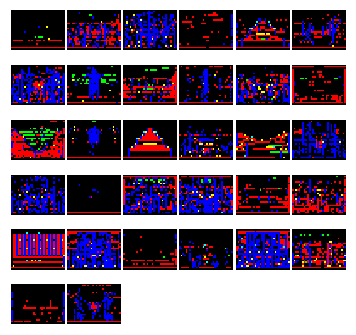

2 th evolution, score_max:1.0, score_min:0.04422,
[0.97812198 0.61343333 1.0001     0.73249437 0.68581429 0.7001
 0.94604595 1.0001     1.0001     0.53856154 0.18319859 0.22629048
 0.04421765 1.0001     1.0001     0.67911235 0.9001     0.09886543
 0.29343333 0.45215479 0.88581429 0.43539412 0.60536316 0.2001
 0.23386623 0.5001     0.15199873 0.17657059 0.15724286 0.56420256
 0.55138205 0.81091081]


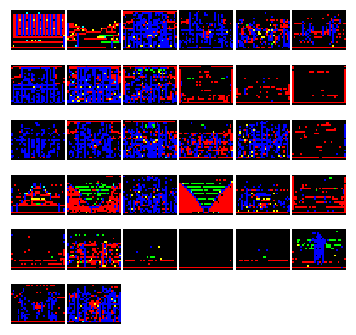

3 th evolution, score_max:1.0, score_min:0.04422,
[0.97307297 1.0001     1.0001     0.26325789 0.24295714 0.72299157
 1.0001     0.46784194 0.87311587 1.0001     0.85116383 1.0001
 0.47570976 0.41568442 0.46488873 0.61676667 0.24667534 0.8962039
 0.60475116 0.12997013 0.96306296 0.72378421 0.07702308 0.4110589
 0.68614651 0.36496486 0.25619756 0.48694211 0.28099888 0.4501
 0.04421765 0.42166863]


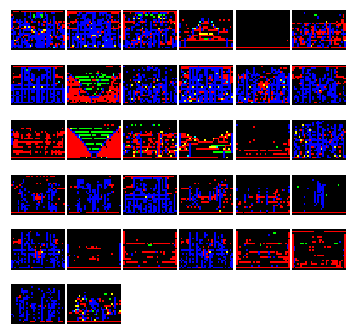

4 th evolution, score_max:1.0, score_min:0.0401,
[0.12775957 0.89715882 0.89343333 0.73343333 1.0001     0.20843333
 1.0001     1.0001     0.80779231 0.0401     1.0001     0.97540864
 0.65724286 1.0001     1.0001     0.07152857 0.22737273 0.43219877
 0.29483684 0.96561724 0.5501     0.70464545 0.97600361 0.77118434
 0.22378421 0.2028027  0.20741707 0.09469459 0.26516024 0.3016873
 1.0001     0.42115263]


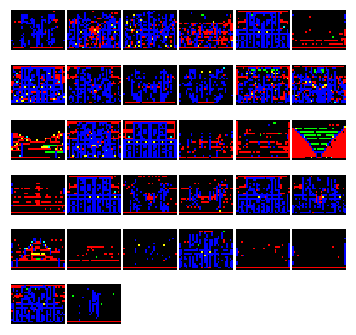

5 th evolution, score_max:1.0, score_min:0.1344,
[1.0001     0.7376     1.0001     0.65343333 0.26516024 1.0001
 0.82232222 0.98539412 1.0001     0.41676667 0.96561724 0.88617595
 0.14935373 0.22901566 0.7973973  1.0001     0.94392022 1.0001
 1.0001     0.15527241 0.87888788 0.32921392 1.0001     0.13442836
 0.14644146 0.20662174 0.27858101 0.30779231 0.42718333 0.95955946
 0.6001     0.13898889]


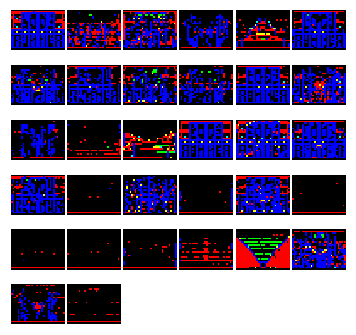

6 th evolution, score_max:1.0, score_min:0.05205,
[0.97657059 1.0001     1.0001     0.37298136 0.7876     0.91149241
 1.0001     1.0001     0.05204805 1.0001     0.62931348 0.26592278
 0.08118108 1.0001     1.0001     0.96212532 0.2501     0.22232222
 0.26383626 0.91149241 0.6376     0.74613175 1.0001     1.0001
 1.0001     0.2001     0.05415405 0.20522821 0.94676667 0.7501
 0.47068824 0.63086923]


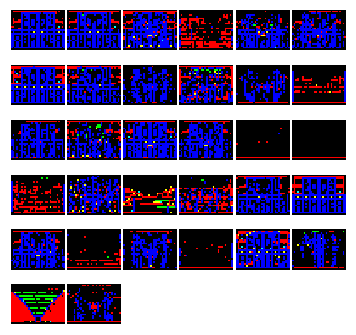

7 th evolution, score_max:1.0, score_min:0.05644,
[0.32362941 0.98775432 0.88415797 0.90550541 0.64393562 0.30676667
 0.68928919 0.20741707 1.0001     1.0001     0.92867143 0.96784194
 1.0001     0.82288481 0.96480588 1.0001     0.98676667 0.75304118
 0.98676667 0.19763086 0.90332581 0.6876     0.23198406 0.62830513
 0.05643803 0.40308507 1.0001     0.79756835 0.08343333 1.0001
 0.97270274 0.51908734]


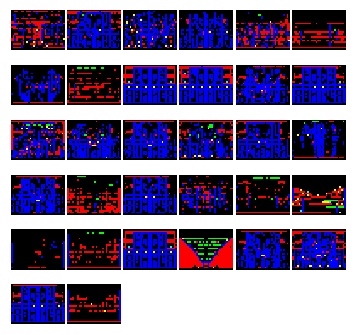

8 th evolution, score_max:1.0, score_min:0.1975,
[0.19746842 0.83960617 0.98397097 1.0001     0.75394615 0.81438571
 0.3251     0.97307297 1.0001     0.38471538 0.77152857 0.98833529
 1.0001     0.52840189 1.0001     1.0001     0.62676667 0.87333944
 0.98343333 1.0001     0.9674913  1.0001     0.96351463 0.4048619
 1.0001     1.0001     0.92217792 1.0001     0.75500196 0.91035641
 0.94515495 0.71438571]


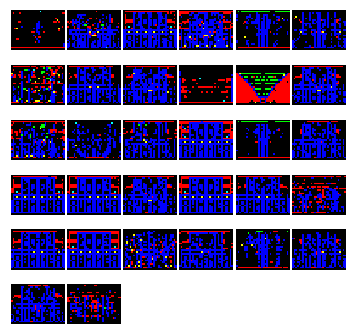

9 th evolution, score_max:1.0, score_min:0.0598,
[1.0001     1.0001     0.7751     0.70598235 1.0001     0.6120403
 0.37047037 1.0001     0.95304118 1.0001     0.82549683 1.0001
 1.0001     1.0001     0.05980149 0.97629048 0.97478354 0.66676667
 0.83833529 1.0001     1.0001     0.8751     0.94376197 0.38281605
 0.98727949 0.06954444 0.94392022 0.9626     0.74400244 1.0001
 0.98517463 0.96438571]


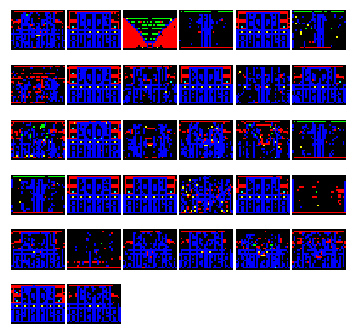

epoch: 8 ,conclusion
raw population


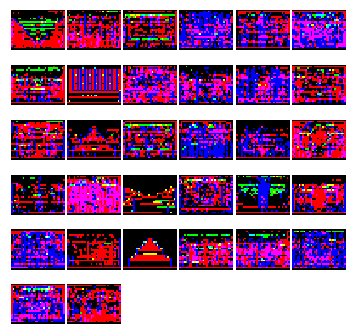

final image


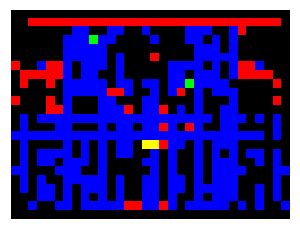

final population


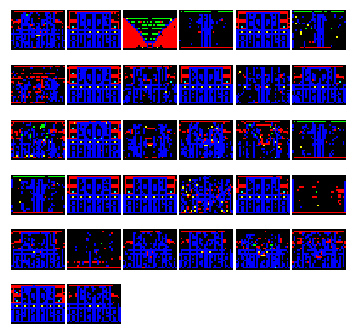

epoch: 9 ,start----------------------------------------------


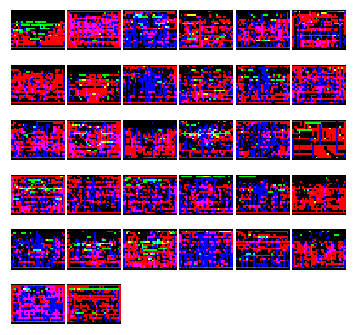

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.0001,
[8.50100000e-01 9.06350000e-01 1.28305128e-01 7.92307792e-01
 2.77877778e-01 7.57242857e-01 9.46045946e-01 1.00010000e+00
 8.33433333e-01 9.88195238e-01 9.14385714e-01 3.97158824e-01
 1.00010000e+00 4.41276471e-01 2.15289873e-01 7.30437079e-01
 1.00010000e+00 9.42176471e-02 4.30655556e-01 2.87600000e-01
 6.91458025e-01 9.10090909e-02 6.62437662e-01 1.03996104e-01
 4.71364368e-01 3.15168493e-01 1.25100000e-01 2.16766667e-01
 4.02697403e-01 9.59904110e-02 1.31052381e-01 1.00000000e-04]
1 th evolution, score_max:1.0, score_min:0.0801,
[0.28957368 0.68549326 0.6001     0.69575217 0.31335301 0.55273158
 0.98640137 0.86895246 1.0001     0.2239806  0.34792609 0.38898889
 1.0001     0.88471538 0.6251     1.0001     0.0801     0.56107561
 0.38393838 0.44295714 0.47152857 0.39516173 0.93268427 0.22545211
 0.32951176 0.94212899 0.86163846 0.35907436 0.61343333 0.35074935
 0.30892353 0.24685325]


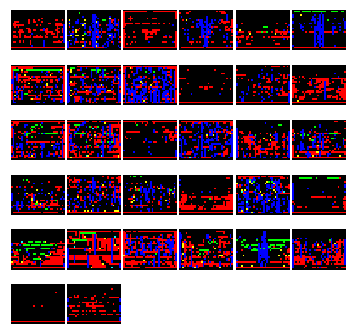

2 th evolution, score_max:1.0, score_min:0.07153,
[0.9376     0.59220526 0.91438571 0.41279841 1.0001     0.6251
 1.0001     1.0001     0.23819524 0.91901892 0.74334324 0.4876
 0.95071728 0.2501     0.33343333 0.34385    1.0001     0.32317692
 0.73819524 0.22982973 0.10853373 0.21696747 0.46488873 0.33776234
 0.2501     0.77037027 0.38038169 0.28957368 1.0001     0.67401304
 0.07152857 0.63105238]


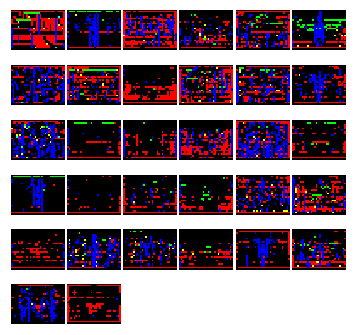

3 th evolution, score_max:1.0, score_min:0.114,
[0.60769494 1.0001     1.0001     0.68125942 0.79771905 0.52818989
 0.39516173 1.0001     0.92434242 0.16893117 0.21136761 0.26163846
 0.48158148 0.24295714 0.8001     0.93431053 1.0001     0.97378421
 0.32193908 0.2001     0.25565556 0.25685676 0.40669341 0.43383494
 0.26398889 0.265725   0.36996301 0.55415405 0.11402405 0.15161515
 0.37343333 0.30655161]


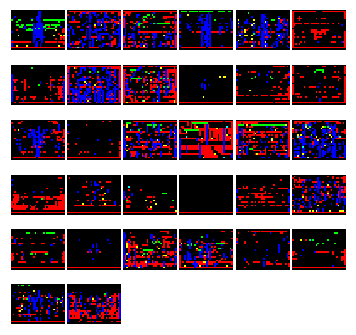

4 th evolution, score_max:1.0, score_min:0.1712,
[0.91186471 1.0001     1.0001     0.54064054 0.43065556 0.97657059
 0.48658649 1.0001     0.96163846 0.76633377 0.36629718 0.86676667
 0.67787778 0.21343333 0.20522821 0.21358315 0.4001     0.90676667
 0.3126     0.74586271 0.24715882 0.7501     0.42115263 0.27390952
 0.26875672 0.17115263 0.19454444 0.56070606 0.17867143 0.50547634
 0.41676667 0.22378421]


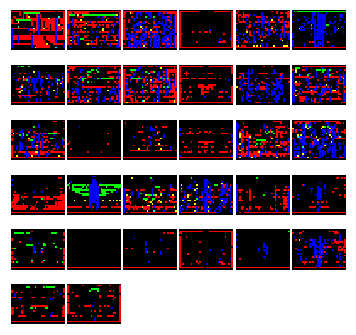

5 th evolution, score_max:1.0, score_min:0.139,
[0.8975359  0.47378421 0.2501     0.43599744 0.26239508 0.34256575
 1.0001     0.15672651 0.2501     1.0001     0.13898889 0.73982603
 0.20299855 0.16676667 0.47445897 0.82201781 0.90919091 0.30565556
 0.8046977  0.2001     0.46278657 0.26163846 0.15078493 0.2001
 0.32477532 0.55182414 0.20234719 0.25685676 0.96521628 0.2279481
 0.33343333 0.53741343]


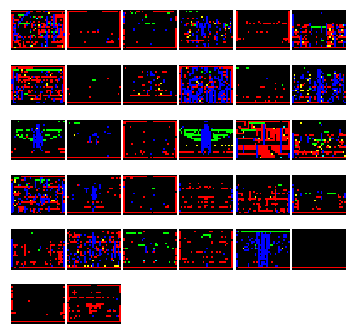

6 th evolution, score_max:1.0, score_min:0.152,
[0.87022987 0.35453038 0.27390952 0.546975   0.84100909 0.55233881
 0.96062632 0.20522821 1.0001     1.0001     0.75334675 0.43488261
 0.19057619 0.24295714 0.88471538 0.28581429 0.58676667 0.18676667
 0.38971039 0.25767576 0.20699655 0.15199873 0.33343333 0.25311205
 0.36629718 0.18614651 1.0001     0.89483684 0.29176667 0.65527241
 0.19158936 0.15502958]


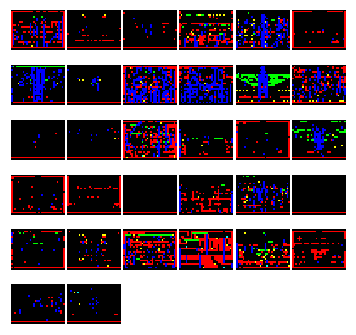

7 th evolution, score_max:1.0, score_min:0.03807,
[0.23694211 0.19763086 0.82676667 1.0001     0.22590645 0.17251379
 0.39295714 0.44837586 1.0001     0.50627284 1.0001     0.953225
 0.68431053 0.9876     0.57981014 1.0001     0.42676667 0.15078493
 0.8453381  0.5001     0.2801     0.87814878 0.26676667 0.2184908
 0.65227391 0.87022987 0.55854156 0.13934051 0.03807468 0.24106386
 0.18431053 0.26480588]


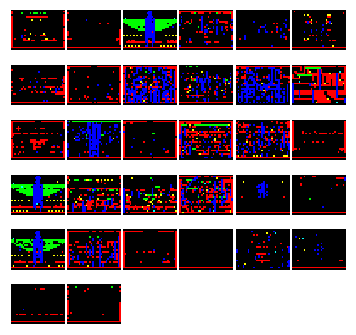

8 th evolution, score_max:1.0, score_min:0.06393,
[0.2346679  0.58237848 1.0001     0.44746842 1.0001     0.23605506
 0.96163846 0.2501     0.78092192 0.19522195 0.18191818 0.26933077
 0.21062632 0.98494848 0.25326456 0.2346679  0.98601549 0.77787778
 0.44881795 0.23265814 0.74203548 0.46845443 0.23297671 0.19364839
 0.46278657 0.20222766 0.59732222 0.21343333 0.06392979 0.18065556
 0.93949394 0.79528072]


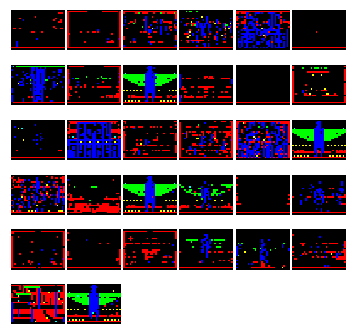

9 th evolution, score_max:1.0, score_min:0.0751,
[0.78388378 0.78957368 0.38471538 0.3165557  0.2028027  0.98847209
 0.79462055 0.98711299 1.0001     0.25935926 0.45108039 0.0751
 0.95248095 0.2346679  0.49360649 0.31157541 0.85493871 0.36121111
 0.78797879 0.17867143 0.79230779 0.26875672 0.11604203 0.50694932
 0.23694211 0.1972831  0.2001     0.09343333 0.19057619 0.45248095
 0.08984359 0.1970697 ]


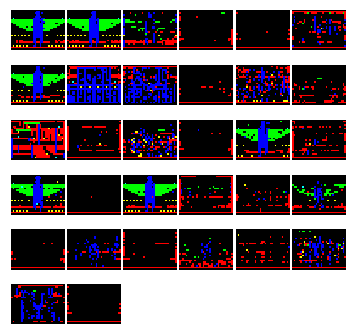

epoch: 9 ,conclusion
raw population


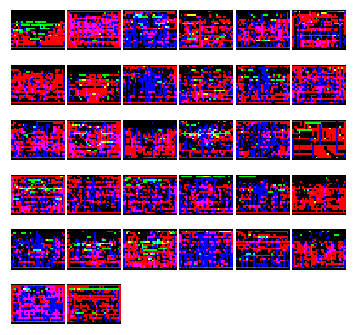

final image


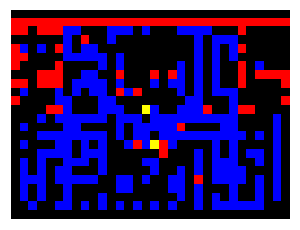

final population


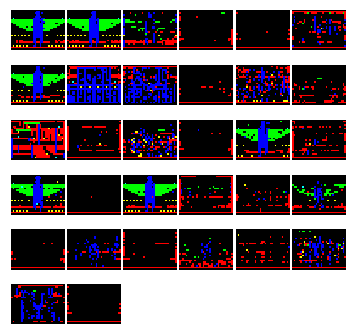

------------final round------------
(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.9852,
[1.0001     0.98694211 0.98640137 1.0001     1.0001     1.0001
 1.0001     0.98517463 1.0001     1.0001    ]
1 th evolution, score_max:1.0, score_min:0.1861,
[0.9601     0.8401     1.0001     0.18614651 1.0001     1.0001
 1.0001     0.98711299 0.98957368 1.0001    ]


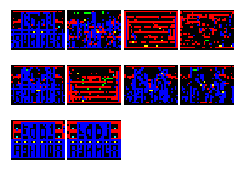

2 th evolution, score_max:1.0, score_min:0.218,
[0.91438571 0.98744177 1.0001     1.0001     0.98658649 1.0001
 0.21804872 1.0001     1.0001     1.0001    ]


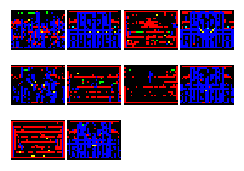

3 th evolution, score_max:1.0, score_min:0.174,
[1.0001     1.0001     0.98886404 1.0001     1.0001     0.73621111
 1.0001     1.0001     0.17401304 0.87189487]


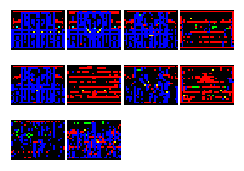

4 th evolution, score_max:1.0, score_min:0.4714,
[0.98833529 1.0001     0.94530548 1.0001     1.0001     0.98790488
 1.0001     0.76605745 1.0001     0.47136437]


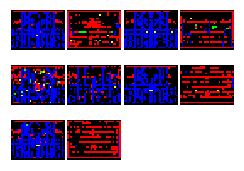

5 th evolution, score_max:1.0, score_min:0.5287,
[0.52867143 0.98790488 0.94746842 1.0001     1.0001     0.95784648
 1.0001     0.80256914 0.98819524 1.0001    ]


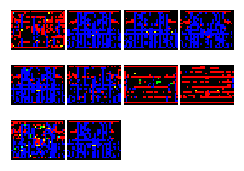

6 th evolution, score_max:1.0, score_min:0.6748,
[0.75816452 0.91368025 1.0001     0.97232222 1.0001     0.96979697
 0.6747988  1.0001     1.0001     1.0001    ]


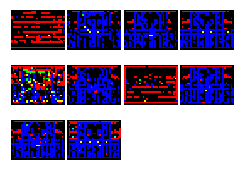

7 th evolution, score_max:1.0, score_min:0.09101,
[1.0001     0.92115263 0.66243766 0.97600361 0.91438571 1.0001
 1.0001     0.98711299 0.09100909 0.31044483]


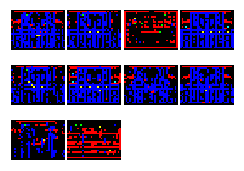

8 th evolution, score_max:1.0, score_min:0.3581,
[0.35812469 0.98727949 0.95598235 0.96561724 0.98658649 1.0001
 1.0001     1.0001     0.96212532 0.97478354]


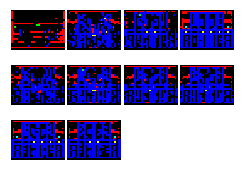

9 th evolution, score_max:1.0, score_min:0.8134,
[1.0001     0.81343333 0.91535424 1.0001     0.8751     0.92317692
 1.0001     1.0001     0.90287778 1.0001    ]


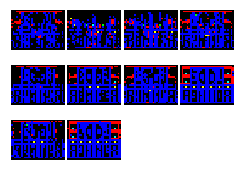

10 th evolution, score_max:1.0, score_min:0.8781,
[0.98727949 1.0001     0.98860575 0.9126     0.87814878 1.0001
 0.98694211 0.98658649 1.0001     0.96480588]


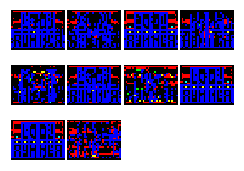

11 th evolution, score_max:1.0, score_min:0.8903,
[1.0001     1.0001     0.98658649 0.96212532 1.0001     1.0001
 0.92657059 0.8903439  0.98517463 1.0001    ]


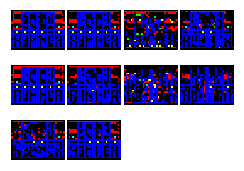

12 th evolution, score_max:1.0, score_min:0.795,
[1.0001     1.0001     1.0001     0.98560725 0.98923043 0.86085949
 1.0001     0.79497179 0.84425584 0.90676667]


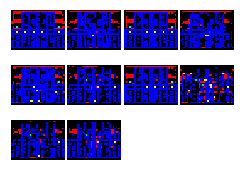

13 th evolution, score_max:1.0, score_min:0.762,
[0.98873636 1.0001     1.0001     0.9751     0.91676667 0.76200476
 1.0001     0.94907959 1.0001     0.79022346]


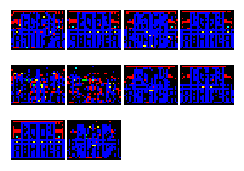

14 th evolution, score_max:1.0, score_min:0.07153,
[0.07152857 0.97378421 0.76722329 1.0001     0.94604595 1.0001
 1.0001     0.96113896 1.0001     0.7201    ]


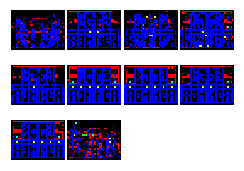

15 th evolution, score_max:1.0, score_min:0.4584,
[1.0001     0.45843333 0.7655321  0.98727949 0.95708925 1.0001
 1.0001     1.0001     1.0001     0.9517129 ]


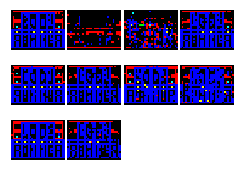

16 th evolution, score_max:1.0, score_min:0.7102,
[0.96306296 0.98676667 0.91035641 0.91149241 1.0001     1.0001
 1.0001     1.0001     0.71024493 1.0001    ]


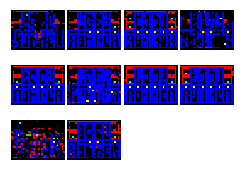

17 th evolution, score_max:1.0, score_min:0.7214,
[1.0001     0.97378421 1.0001     0.8903439  0.72141148 1.0001
 1.0001     0.94057619 0.94262874 0.96561724]


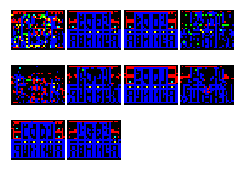

18 th evolution, score_max:1.0, score_min:0.683,
[0.9751     0.98911099 0.92115263 0.92317692 1.0001     1.0001
 0.8359209  1.0001     0.98898889 0.68302683]


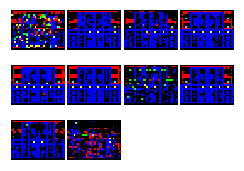

19 th evolution, score_max:1.0, score_min:0.7161,
[0.84715882 0.98744177 0.83833529 0.98833529 0.90919091 0.94240769
 0.78957368 0.98819524 0.71614938 1.0001    ]


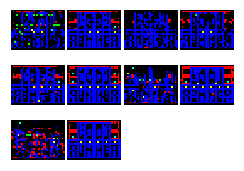

20 th evolution, score_max:1.0, score_min:0.5935,
[0.92217792 1.0001     0.98711299 1.0001     0.93033256 0.9048619
 0.90919091 0.59350659 1.0001     0.83554304]


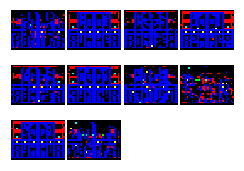

21 th evolution, score_max:1.0, score_min:0.8296,
[1.0001     0.97378421 0.93912439 1.0001     0.95515618 0.92547313
 0.97270274 1.0001     0.82964545 0.84385   ]


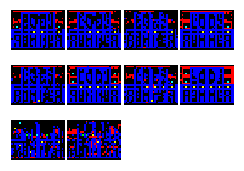

22 th evolution, score_max:1.0, score_min:0.8119,
[0.96306296 0.98775432 1.0001     1.0001     1.0001     1.0001
 0.89199189 0.81186471 0.97193099 0.95955946]


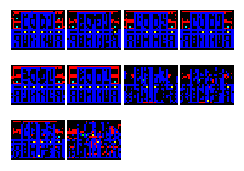

23 th evolution, score_max:1.0, score_min:0.5367,
[0.95900411 0.72629048 0.53668537 1.0001     0.96212532 0.9517129
 0.95843333 0.8251     0.92166863 0.97193099]


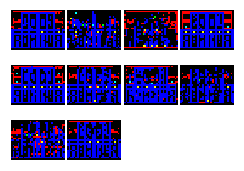

24 th evolution, score_max:1.0, score_min:0.0598,
[0.87664321 0.98805181 0.87351772 1.0001     0.96306296 1.0001
 0.95515618 0.85084627 0.05980149 1.0001    ]


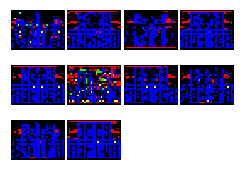

25 th evolution, score_max:1.0, score_min:0.2858,
[1.0001     0.95304118 0.97193099 0.98315085 0.28581429 0.79230779
 0.8376     1.0001     0.89343333 0.88898889]


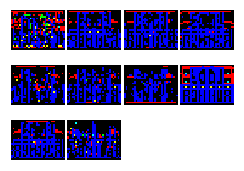

26 th evolution, score_max:1.0, score_min:0.6754,
[0.67542468 0.88742394 0.97193099 0.98775432 1.0001     0.8962039
 0.91559296 1.0001     0.9376     0.95248095]


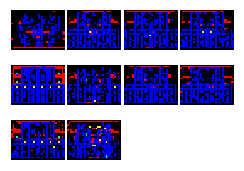

27 th evolution, score_max:1.0, score_min:0.7144,
[1.0001     0.87333944 0.93488261 0.86878687 0.98775432 0.96212532
 0.97232222 0.71438571 0.97600361 0.95955946]


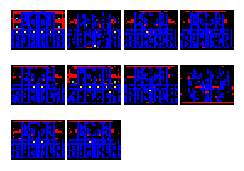

28 th evolution, score_max:1.0, score_min:0.7232,
[1.0001     0.72317692 0.97600361 0.90750741 0.97859462 0.90635
 0.97378421 0.9011989  0.90779231 0.95784648]


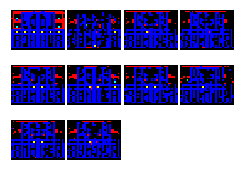

29 th evolution, score_max:1.0, score_min:0.8631,
[0.95724286 0.94454444 0.94127647 0.97412597 1.0001     0.94815195
 0.87961807 0.93949394 0.8631137  0.90371446]


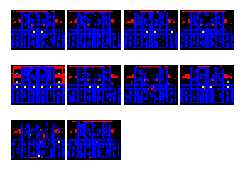

30 th evolution, score_max:1.0, score_min:0.8494,
[0.93160685 1.0001     0.9626     0.94057619 0.98934731 0.8801
 0.93949394 1.0001     0.93680886 0.84941507]


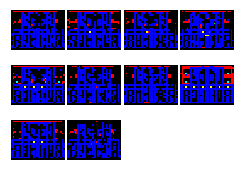

31 th evolution, score_max:1.0, score_min:0.8194,
[0.87847838 0.95955946 1.0001     1.0001     0.98471538 0.91368025
 0.97629048 1.0001     0.81937711 0.90420959]


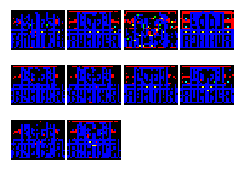

32 th evolution, score_max:1.0, score_min:0.8109,
[0.95358837 0.98847209 0.8751     1.0001     0.97600361 0.92763623
 0.91035641 0.98873636 0.81091081 0.96835397]


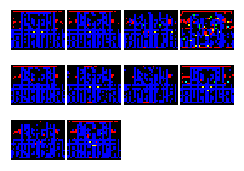

33 th evolution, score_max:1.0, score_min:0.8453,
[0.89421765 1.0001     0.98517463 0.9674913  0.92951176 0.8453381
 1.0001     0.88581429 0.94746842 0.90799474]


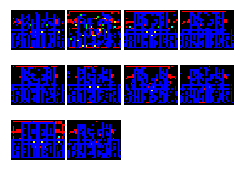

34 th evolution, score_max:0.9648, score_min:0.0876,
[0.9001     0.0876     0.54939577 0.94262874 0.85084627 0.96480588
 0.91368025 0.76933077 0.94057619 0.91149241]


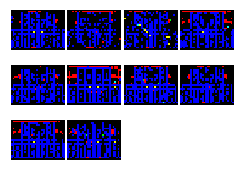

35 th evolution, score_max:1.0, score_min:0.5617,
[0.83554304 1.0001     0.87022987 0.56174384 0.96163846 0.85195185
 0.86852105 0.87022987 0.89421765 0.96713297]


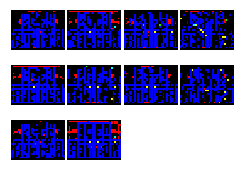

36 th evolution, score_max:0.9507, score_min:0.3211,
[0.89883418 0.77343333 0.86429753 0.89665172 0.82936829 0.80565556
 0.95071728 0.6836443  0.8001     0.32108765]


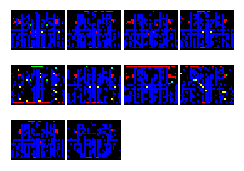

37 th evolution, score_max:0.9356, score_min:0.7398,
[0.84755763 0.74693544 0.73982603 0.85536316 0.75959367 0.93558387
 0.86496486 0.87961807 0.90150845 0.8256814 ]


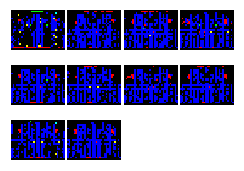

38 th evolution, score_max:0.9536, score_min:0.4063,
[0.77932078 0.84517042 0.78491013 0.84156341 0.86429753 0.76933077
 0.77474789 0.95358837 0.85343333 0.40635   ]


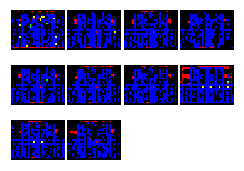

39 th evolution, score_max:0.8653, score_min:0.365,
[0.82362941 0.8376     0.86526854 0.84136984 0.79079767 0.76633377
 0.76633377 0.86325789 0.85724286 0.36496486]


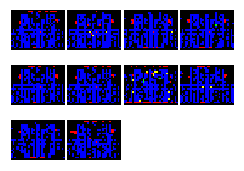

raw population


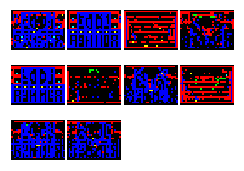

final image


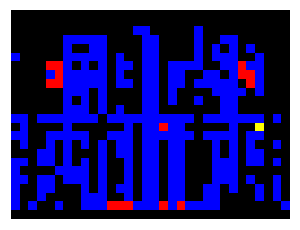

final population


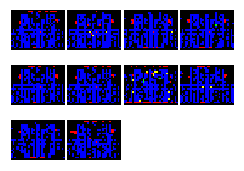

final level candate


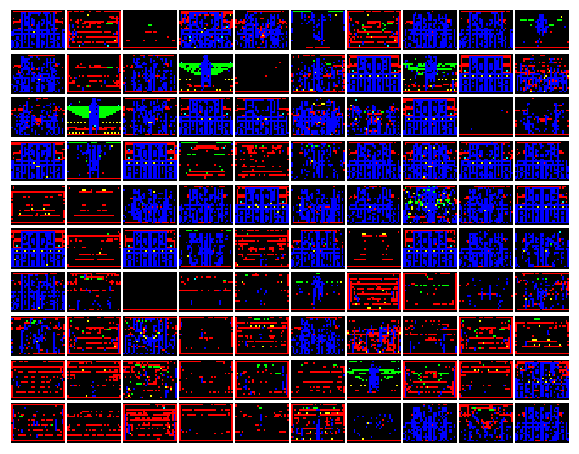

In [57]:
#evo param
evo_in_path = "e://python3/vae_v4.npy"
crossover_rate = 0.9
mutate_rate = 0.1
n_population = 32
n_iterations = 10   #total iteration = (9+1)*3=30  #time complexity = 30*3*9* O(Astar)= (np*ni)**2 *astar
#------------------------------------------------------------------
rawset = np.load(evo_in_path)
np.random.shuffle(rawset)

#data = np.random.randint(0,2,size=(n_population,DNA_size)).astype(np.int8)
extra_set = []
final_set = []
st = 0

for i in range(10):  #n_population
    print('epoch:',i,',start----------------------------------------------')
    idx = np.random.choice(np.arange(rawset.shape[0]), size=n_population, replace=False)
    img_in = rawset[idx]
    Util.disp_images(img_in) 
    gene = Util.img2gene(img_in)   
    ga = Generic(gene,rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=n_population,
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations)
    ga.evolution()
    print('epoch:',i,',conclusion')
    print('raw population')
    Util.disp_images(img_in) 
    print('final image')
    Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
    print('final population')
    Util.disp_images(ga.population) 
    final_set,st = (np.vstack((final_set,ga.population)),1) if st==1 else (ga.population,1)
    extra_set.append(ga.best_person)
    
print('------------final round------------')
ga = Generic(np.array(extra_set),rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=min(len(extra_set),n_population),
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations*4)
ga.evolution()

print('raw population')
Util.disp_images(np.array(extra_set)) 

print('final image')
Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
print('final population')
Util.disp_images(ga.population) 

final_set = np.vstack((final_set,ga.population))
print('final level candate')
Util.disp_images(np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),figsize=(10.0, 8.0)) 
np.save("evolution_v4",np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),allow_pickle=False,fix_imports=True)


(330, 3840)


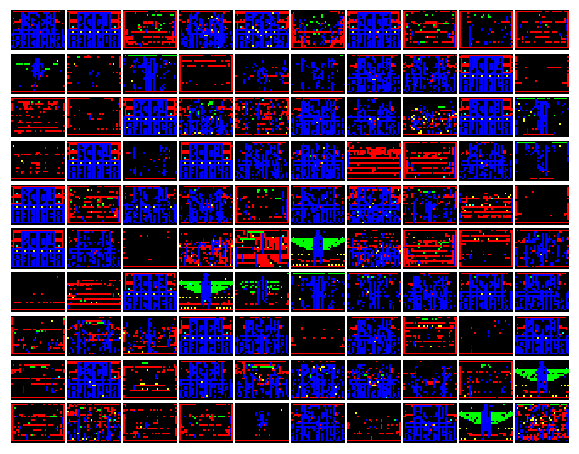

In [95]:
sth = np.load("e://python3/evolution_v4.npy")
print(sth.shape)
np.random.shuffle(sth)
_ = disp_images(sth[:100],figsize=(10.0, 8.0))

(7, 24, 32, 5)


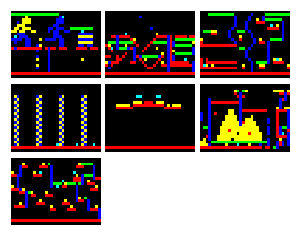

In [42]:
wanted = sth[[15,32,67,131,134,238,300]].reshape([-1,gb_w,gb_h,gb_c])
print(wanted.shape)
np.save("AE",wanted,allow_pickle=False,fix_imports=True)
test = np.load("e://python3/AE.npy")
_ = disp_images(test,figsize=(5.0, 4.0))

(300, 24, 32, 5)
(330, 24, 32, 5)


e:\learning software\python\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


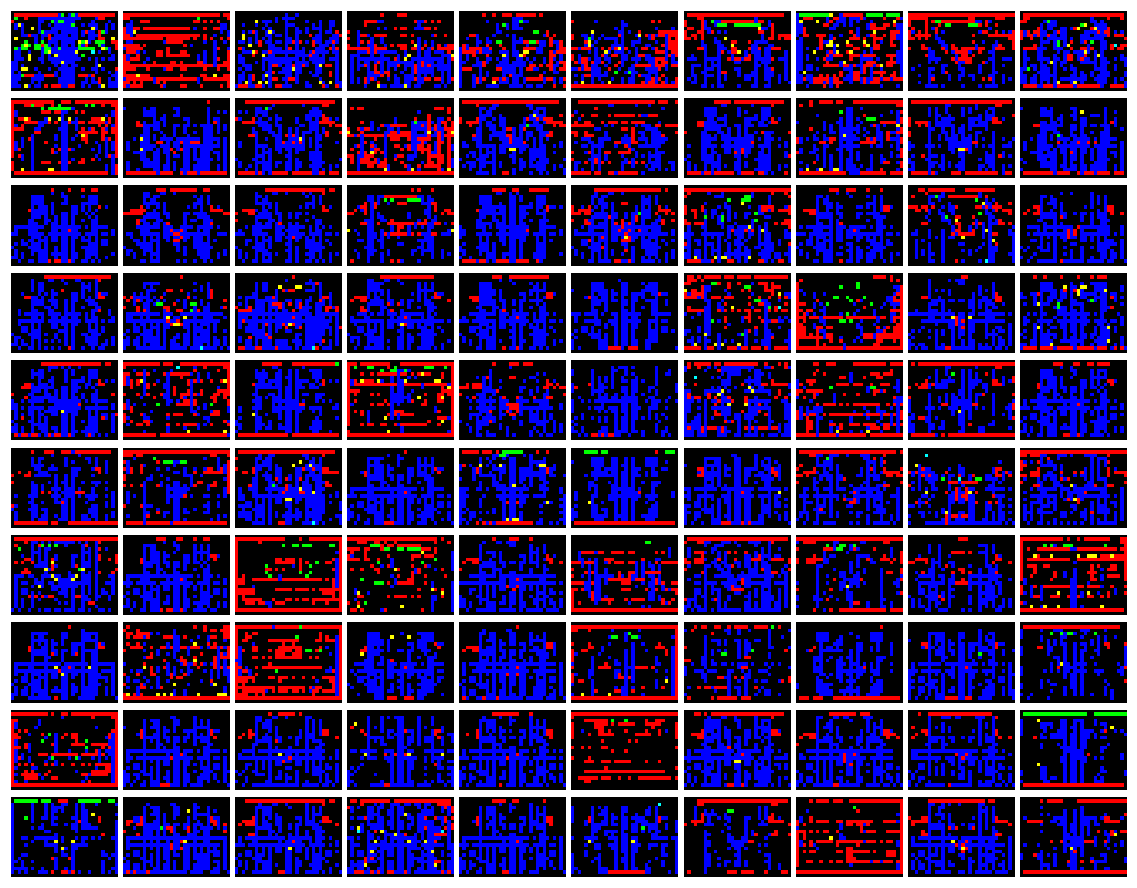

[0.53645833 0.58072917 0.58203125 0.5859375  0.60677083 0.609375
 0.61848958 0.61979167 0.62109375 0.625      0.62630208 0.62890625
 0.63020833 0.63151042 0.63151042 0.6328125  0.6328125  0.6328125
 0.6328125  0.6328125  0.63411458 0.63671875 0.63802083 0.63802083
 0.640625   0.64192708 0.64192708 0.64192708 0.64192708 0.64322917
 0.64322917 0.64453125 0.64453125 0.6484375  0.6484375  0.6484375
 0.64973958 0.64973958 0.65104167 0.65234375 0.65755208 0.65885417
 0.65885417 0.66015625 0.66145833 0.66536458 0.66536458 0.66536458
 0.66666667 0.66666667 0.66796875 0.66796875 0.67317708 0.67447917
 0.67447917 0.67708333 0.67708333 0.67708333 0.68098958 0.68229167
 0.68359375 0.68359375 0.68489583 0.68489583 0.68619792 0.68619792
 0.6875     0.6875     0.6875     0.6875     0.6875     0.68880208
 0.68880208 0.69010417 0.69140625 0.69401042 0.6953125  0.6953125
 0.6953125  0.69661458 0.69791667 0.69791667 0.69791667 0.69921875
 0.70182292 0.70182292 0.70442708 0.70442708 0.70572917 0.70572917


In [134]:
imageMatrix1 = np.load(input_path)[:150]
imageMatrix2 = data_augumentation(imageMatrix1)
imageMatrix1 = np.vstack((imageMatrix1,imageMatrix2))
imageMatrix1 = imageMatrix1[0:300]  #----------------------------------
base = imageMatrix1[:300].copy()
test = sth.reshape([-1,24,32,5]).copy()

print(base.shape)
print(test.shape)
saved_base = base
saved_test = test

ec_imglist1 = []
for i in range(base.shape[0]):
    #print('process ',i)
    ec_img, _ = Util.encoding_img(base[i])
    ec_imglist1.append(ec_img)
ec_imglist1 = np.array(ec_imglist1)
base = ec_imglist1


ec_imglist2 = []
for i in range(test.shape[0]):
    #print('process ',i)
    ec_img, _  = Util.encoding_img(test[i])
    ec_imglist2.append(ec_img)
ec_imglist2 = np.array(ec_imglist2)
test = ec_imglist2

base[base==0] = 10
res = []
for t in test:
    similarmax = 0
    for b in base:
        similarmax = max(similarmax,np.mean(t==b))
    res.append(similarmax)

res = np.array(res)
_ = disp_images(saved_test[np.argsort(res)],figsize=(20.0, 16.0))
print(np.abs(np.sort(res)))
